# XGB Model Training and SHAP computation -- Synthetic Dataset

**Author: Tesfagabir Meharizghi<br>
Edited by: Lin Lee Cheong
Last Updated: 03/04/2021**

In this jupyter notebook, we trained XGB models by manually tuning their parameters to get the best performance and explainability scores from the different datasets.

Tasks done here are:
- Training XGB models with the specified parameters and datasets
- Computing different model performance measures such as AUCs, intersection similarity, RBOs, etc.
- Visualizing global and local SHAP scores
- And finally copying the well trained models to S3 if needed

Outputs:
- The following artifacts are saved:
    * Model artifacts
    * SHAP values and their corresponding scores for the specified number of val/test examples

Model Architecture Used:
- XGB

Dataset:
- Synthetic Dataset

Requirements:
- Make sure that you have already generated sequence-based dataset (train/val/test splits) using [Create_toy_dataset_sequence.ipynb](../../../data/toy_dataset/Create_toy_dataset_sequence.ipynb).

Discussions/observations:
- Since the models' parameters are manually specified with the best ones, we could get almost the best performance in terms of its AUCs and explainability scores.
- In addition, we could also get almost perfect global SHAP importance scores where all the important events are selected.

Cases and Observations:
- Increasing the token variety for each category
      - Performance and importance scores didn't change from that of lower number of tokens
      - The same also for 30 & 300 seq lengths (didn't change performance)
- Decreasing the 0.99 prob for the ad_seq to 0.8
    - The models' performance lowered
        - 87% --> 83% AUC
    - Sequence lengths didn't make a difference        

In [1]:
# pip install nb-black

In [2]:
#! pip install botocore==1.12.201

#! pip install shap
#! pip install xgboost

In [3]:
#%load_ext lab_black

%load_ext autoreload

%autoreload 2

In [4]:
import sys

sys.path.append("../")

import os
import time
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.inspection import permutation_importance
import re
from scipy import stats

#!pip install -e git+https://github.com/changyaochen/rbo.git@master#egg=rbo
import rbo

from urllib.parse import urlparse
import tarfile
import pickle
import shutil
from collections import Counter, defaultdict, OrderedDict

import shap
import xgboost as xgb

import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.image_uris import retrieve

import xgboost_utils as xgb_utils
import shap_jacc_utils as sj_utils

## XGB Model Training

### Constants

In [5]:
# Feature suffices that help predict the positive or negative class
HELPING_FEATURES_SUFFICES = ["_A", "_H", "_U"]  # Noises Removed

TRAIN_MODEL = True

# Whether to preprocess data
PREPROCESS_DATA = True

# Whether to save SHAP scores
SAVE_SHAP_OUTPUT = True

# Whether to ouput SHAP explainer expected value
OUTPUT_SHAP_EXPLAINER = True

# Whether to shuffle val & test dataset for shap visualization purposes
SHUFFLE = False

# For seq_len=30
seq_len = 30

USE_FREQ = True  # Whether to use feature frequencies or one-hot for data preprocessing

nrows = 1e9

target_colname = "label"
uid_colname = "patient_id"
target_value = "1"

rev = False

model_name = "xgb"
dataset = "synthetic-event-driven-lchw"

# For model early stopping criteria
EARLY_STOPPING = "intersection_similarity"  # Values are any of these: ['intersection_similarity', 'loss']

# SHAP related constants
N_BACKGROUND = 300  # Number of background examples
BACKGROUND_NEGATIVE_ONLY = True  # If negative examples are used as background
BACKGROUND_POSITIVE_ONLY = False  # If positive examples are used as background
TEST_POSITIVE_ONLY = False  # If only positive examples are selected
IS_TEST_RANDOM = (
    False  # If random test/val examples are selected for shap value computation
)
SORT_SHAP_VALUES = False  # Whether to sort per-patient shap values for visualization

SHAP_SCORE_ABSOLUTE = True  # Whether to consider the absolute value of a shap score #TODO: Check this before running.


train_data_path = f"../../../data/time_diff_toy_dataset_v3/event_based/{seq_len}/train.csv"
valid_data_path = f"../../../data/time_diff_toy_dataset_v3/event_based/{seq_len}/val.csv"
test_data_path = f"../../../data/time_diff_toy_dataset_v3/event_based/{seq_len}/test.csv"

model_save_path = (
    f"./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/{seq_len}/{model_name}/models/model_{'{}'}.pkl"
)
shap_save_path_pattern = f"./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/{seq_len}/{model_name}/shap/{'{}'}_shap_{'{}'}.pkl"  # SHAP values path for a given dataset split (train/val/test) (data format (features, scores, patient_ids))

# Dataset preprocessing
x_train_one_hot_path = f"./output/time_diff_toy_dataset_v3/event_based/{seq_len}/{model_name}/data/train_one_hot.csv"
x_valid_one_hot_path = f"./output/time_diff_toy_dataset_v3/event_based/{seq_len}/{model_name}/data/val_one_hot.csv"
x_test_one_hot_path = f"./output/time_diff_toy_dataset_v3/event_based/{seq_len}/{model_name}/data/test_one_hot.csv"

x_train_data_path = f"./output/time_diff_toy_dataset_v3/event_based/{seq_len}/{model_name}/data/train.csv"
x_valid_data_path = f"./output/time_diff_toy_dataset_v3/event_based/{seq_len}/{model_name}/data/val.csv"
x_test_data_path = f"./output/time_diff_toy_dataset_v3/event_based/{seq_len}/{model_name}/data/test.csv"

s3_output_data_dir = (
    f"s3://merck-paper-bucket/{dataset}/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/{seq_len}/data"
)

# Model training
BUCKET = "merck-paper-bucket"
DATA_PREFIX = f"{dataset}/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/{seq_len}/data"
MODEL_PREFIX = f"{dataset}/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/{seq_len}/{model_name}".format(seq_len)
label = "label"

output_results_path = (
    f"output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/{seq_len}/{model_name}/train_results/results.csv"
)
PARAMS_PATH = (
    f"output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/{seq_len}/{model_name}/train_results/model_params.json"
)

local_model_dir = f"output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/{seq_len}/{model_name}/models/"
s3_output_path = f"s3://{BUCKET}/{MODEL_PREFIX}/output"

###Algorithm config
ALGORITHM = "xgboost"
REPO_VERSION = "1.2-1"

EARLY_STOPPING_ROUNDS = 5

MODEL_PARAMS = {
    "n_jobs": 25,
    "random_state": 7,
    "max_depth": 8,
    "n_estimators": 500,
    "eval_metric": "auc",
    "learning_rate": 0.3,
    "reg_alpha": 0.2,
    "reg_lambda": 0.3,
    "colsample_bytree": 0.35,
    "use_label_encoder": False,
}
# EARLY_STOPPING_ROUNDS = 5

# MODEL_PARAMS = {
#     "n_jobs": 25,
#     "random_state": 10,
#     "max_depth": 2,
#     "n_estimators": 500,
#     "eval_metric": "auc",
#     "learning_rate": 0.3,
#     "reg_alpha": 0.2,
#     "reg_lambda": 0.3,
#     "colsample_bytree": 0.35,
#     "use_label_encoder": False,
# }

In [6]:
if TRAIN_MODEL:
    # Model Output Directory
    model_save_dir = os.path.dirname(model_save_path)
    shap_save_dir = os.path.dirname(shap_save_path_pattern)

    if os.path.exists(model_save_dir):
        # Remove model save directory if exists
        shutil.rmtree(model_save_dir)
    if os.path.exists(shap_save_dir):
        # Remove model save directory if exists
        shutil.rmtree(shap_save_dir)
    os.makedirs(model_save_dir)
    os.makedirs(shap_save_dir)
    print(f"New directory created: {model_save_dir}")
    print(f"New directory created: {shap_save_dir}")

New directory created: ./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/models
New directory created: ./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap


## 2. XGBoost Model Training

### Data Preprocessing

In [7]:
df = pd.read_csv(train_data_path)
print(df.shape)
df.head()

(21000, 33)


29             28                      27  \
0  electrical_cardioversion_U     backache_N                myopia_N   
1                  backache_N     backache_N              backache_N   
2                 cold_sore_N  dental_exam_N             foot_pain_N   
3       elevated_creatinine_H    hay_fever_N           quad_injury_N   
4           annual_physical_N  quad_injury_N  ventricular_aneurysm_A   

               26                     25                 24  \
0  ankle_sprain_N         ankle_sprain_N  annual_physical_N   
1  ingrown_nail_N             ACL_tear_N           myopia_N   
2     foot_pain_N      annual_physical_N     ankle_sprain_N   
3     cold_sore_N  heart_valve_failure_A  annual_physical_N   
4      backache_N       peanut_allergy_N      sleep_apnea_H   

                  23                    22                     21  \
0              ARB_U        ankle_sprain_N               myopia_N   
1         backache_N            ACL_tear_N  heart_valve_failure_A   
2         headache_N        ankle_sprain_N         ankle_sprain_N   
3  annual_physical_N  metabolic_disorder_H          quad_injury_N   
4     ingrown_nail_N            eye_exam_N             headache_N   

                          20  ...                        6               5  \
0  ventricular_hypertrophy_A  ...                    <pad>           <pad>   
1      elevated_creatinine_H  ...                    <pad>           <pad>   
2              quad_injury_N  ...  sleep_apnea_treatment_U  ankle_sprain_N   
3                   myopia_N  ...                    <pad>           <pad>   
4             hypertension_A  ...             cut_finger_N    cut_finger_N   

             4             3           2      1      0  patient_id label  \
0        <pad>         <pad>       <pad>  <pad>  <pad>  H2LAUWYZA2     0   
1        <pad>         <pad>       <pad>  <pad>  <pad>  FGS87DEFXS     1   
2  hay_fever_N  cut_finger_N  eye_exam_N  <pad>  <pad>  CFLC29YT6I     0   
3        <pad>         <pad>       <pad>  <pad>  <pad>  R66RAQG447     1   
4        <pad>         <pad>       <pad>  <pad>  <pad>  CX57PGHWAX     1   

  category  
0      AUU  
1      AAH  
2      HUU  
3      AHH  
4      AAH  

[5 rows x 33 columns]

In [8]:
tokens = xgb_utils.get_valid_tokens(df, seq_len)

In [9]:
if PREPROCESS_DATA:
    xgb_utils.prepare_data(
        train_data_path,
        x_train_one_hot_path,
        x_train_data_path,
        seq_len,
        target_colname,
        tokens,
        s3_output_data_dir,
        use_freq=USE_FREQ,
    )
    xgb_utils.prepare_data(
        valid_data_path,
        x_valid_one_hot_path,
        x_valid_data_path,
        seq_len,
        target_colname,
        tokens,
        s3_output_data_dir,
        use_freq=USE_FREQ,
    )
    xgb_utils.prepare_data(
        test_data_path,
        x_test_one_hot_path,
        x_test_data_path,
        seq_len,
        target_colname,
        tokens,
        s3_output_data_dir,
        use_freq=USE_FREQ,
    )
# else:
#     local_dir = os.path.dirname(x_train_data_path)
#     xgb_utils.copy_data_to_s3(local_dir, s3_output_data_dir)

Sucess!
Sucess!
Sucess!


### XGBoost Model Training

In [10]:
def load_xgb_classifier(model_path, model_params):
    """Load XGBClassifier model from saved Booster model."""
    xgb_model = xgb.XGBClassifier(**model_params)
    # xgb_model.set_params()
    xgb_model._Booster = sj_utils.load_pickle(model_path)
    return xgb_model


def get_model_paths(model_save_dir, sort=True):
    """Get list models paths in sorted order if needed."""
    fnames = os.listdir(model_save_dir)
    if sort:
        fnames.sort(key=lambda f: int(re.sub("\D", "", f)))
    model_paths = [os.path.join(model_save_dir, fname) for fname in fnames]
    return model_paths


def get_wtau(x, y):
    return stats.weightedtau(x, y, rank=None)[0]


# calculate ground truth scores
def is_value(x):
    if x.endswith("_N"):
        return False
    return True


def get_model_intersection_similarity_v2(features_scores, absolute=True):
    # gt similarity
    all_features, all_scores = features_scores[0], features_scores[1]
    sims = []
    for i, features in enumerate(all_features):
        scores = all_scores[i]
        gt_features = [feature for feature in features if is_value(feature)]
        n_gt = len(gt_features)
        if n_gt > 0:
            dict_features_scores = sj_utils.create_dict_features_scores(
                features, scores, absolute
            )
            top_features_scores = sj_utils.top_k(dict_features_scores, len(gt_features))
            top_features = top_features_scores[0]
            pred_features = [feature for feature in top_features if is_value(feature)]
            sim = len(set(pred_features).intersection(gt_features)) / float(n_gt)
        else:
            sim = -1
        sims.append(sim)
    avg_sim = sum(sims) / len(sims)
    return avg_sim, sims


def compute_shap(xgb_model, df_train0, df_test0, explainer=None, negative_only=False):
    # Load the copied model
    # xgb_model = sj_utils.load_pickle(model_path)

    df_train = df_train0.copy()
    df_test = df_test0.copy()

    feature_names = [
        col for col in df_train.columns.tolist() if col not in ["patient_id", "label"]
    ]
    
    if negative_only:
        X_train = df_train.loc[df_train.label == 0, feature_names]
    else:
        X_train = df_train[feature_names]
    X_test = df_test[feature_names]

    if explainer is None:
        explainer = shap.TreeExplainer(xgb_model, X_train)
    shap_scores = explainer.shap_values(X_test).tolist()
    features = [feature_names[:]] * X_test.shape[0]
    patients = df_test.patient_id.tolist()

    return ((features, shap_scores, patients), explainer)


def save_results(patients, features, shap_scores, y_true, y_pred, output_path):
    """Save all model training results to file."""
    results = {}
    for i, patient_id in enumerate(patients):
        results[patient_id] = {}
        results[patient_id]["features_xgb"] = features[i]
        results[patient_id]["label"] = y_true[i]
        results[patient_id]["xgb_pred"] = y_pred[i]
        results[patient_id]["xgb_shap"] = shap_scores[i]

    output_dir = os.path.dirname(output_path)
    os.makedirs(output_dir, exist_ok=True)

    sj_utils.save_pickle(results, output_path, verbose=False)
    return results


def get_features_and_global_shap(results, exp_num=1):
    """Get a dataframe of features and global shap values."""
    features = None
    ##Get features and global shap
    all_shap = []
    for patient_id, result in results.items():
        if features is None:
            features = results[patient_id]["features_xgb"]
        all_shap.append(results[patient_id]["xgb_shap"])
    all_shap = np.absolute(np.array(all_shap)).mean(axis=0)
    df_shap = pd.DataFrame()
    df_shap["features"] = features
    df_shap["scores"] = all_shap
    df_shap["exp_num"] = exp_num
    return df_shap

In [11]:
df_train = pd.read_csv(x_train_one_hot_path)
df_val = pd.read_csv(x_valid_one_hot_path)
df_test = pd.read_csv(x_test_one_hot_path)

In [12]:
df_train.head()

patient_id  cardiomyopathy_A  metabolic_disorder_H  \
0  H2LAUWYZA2                 0                     0   
1  FGS87DEFXS                 0                     0   
2  CFLC29YT6I                 0                     0   
3  R66RAQG447                 0                     1   
4  CX57PGHWAX                 0                     0   

   electrical_cardioversion_U  Acute_Myocardial_Infarction_A  pneumonia_H  \
0                           1                              0            0   
1                           0                              0            0   
2                           0                              0            0   
3                           0                              0            0   
4                           0                              0            0   

   cold_sore_N  edema_H  annual_physical_N  ventricular_hypertrophy_A  ...  \
0            0        0                  1                          1  ...   
1            0        0                  0                          0  ...   
2            1        0                  2                          0  ...   
3            2        0                  5                          0  ...   
4            1        0                  1                          0  ...   

   ingrown_nail_N  cardiac_rehab_U  myopia_N  beta_blockers_U  \
0               1                0         2                0   
1               1                0         1                0   
2               2                0         0                0   
3               0                0         1                0   
4               4                0         1                0   

   pulmonary_embolism_A  ACE_inhibitors_U  backache_N  ankle_sprain_N  \
0                     0                 0           3               3   
1                     0                 0           6               0   
2                     0                 0           0               4   
3                     0                 0           0               1   
4                     0                 0           1               0   

   cut_finger_N  label  
0             0      0  
1             1      1  
2             1      0  
3             2      1  
4             3      1  

[5 rows x 47 columns]

In [13]:
count_0 = df_train.label.value_counts()[0]
count_1 = df_train.label.value_counts()[1]
print(
    f"Train Classes Count: 0-->{count_0}, 1-->{count_1}, Total-->{count_0+count_1}",
)

count_0 = df_val.label.value_counts()[0]
count_1 = df_val.label.value_counts()[1]
print(
    f"Val Classes Count: 0-->{count_0}, 1-->{count_1}, Total-->{count_0+count_1}",
)

count_0 = df_test.label.value_counts()[0]
count_1 = df_test.label.value_counts()[1]
print(
    f"Test Classes Count: 0-->{count_0}, 1-->{count_1}, Total-->{count_0+count_1}",
)

print(df_train.shape)
df_train.head()

Train Classes Count: 0-->10821, 1-->10179, Total-->21000
Val Classes Count: 0-->3670, 1-->3330, Total-->7000
Test Classes Count: 0-->3599, 1-->3401, Total-->7000
(21000, 47)


patient_id  cardiomyopathy_A  metabolic_disorder_H  \
0  H2LAUWYZA2                 0                     0   
1  FGS87DEFXS                 0                     0   
2  CFLC29YT6I                 0                     0   
3  R66RAQG447                 0                     1   
4  CX57PGHWAX                 0                     0   

   electrical_cardioversion_U  Acute_Myocardial_Infarction_A  pneumonia_H  \
0                           1                              0            0   
1                           0                              0            0   
2                           0                              0            0   
3                           0                              0            0   
4                           0                              0            0   

   cold_sore_N  edema_H  annual_physical_N  ventricular_hypertrophy_A  ...  \
0            0        0                  1                          1  ...   
1            0        0                  0                          0  ...   
2            1        0                  2                          0  ...   
3            2        0                  5                          0  ...   
4            1        0                  1                          0  ...   

   ingrown_nail_N  cardiac_rehab_U  myopia_N  beta_blockers_U  \
0               1                0         2                0   
1               1                0         1                0   
2               2                0         0                0   
3               0                0         1                0   
4               4                0         1                0   

   pulmonary_embolism_A  ACE_inhibitors_U  backache_N  ankle_sprain_N  \
0                     0                 0           3               3   
1                     0                 0           6               0   
2                     0                 0           0               4   
3                     0                 0           0               1   
4                     0                 0           1               0   

   cut_finger_N  label  
0             0      0  
1             1      1  
2             1      0  
3             2      1  
4             3      1  

[5 rows x 47 columns]

In [14]:
# Get feature names
feature_names = [
    col for col in df_train.columns.tolist() if col not in ["patient_id", "label"]
]

In [15]:
model_save_dir = os.path.dirname(model_save_path)
if TRAIN_MODEL:
    if os.path.exists(model_save_dir):
        shutil.rmtree(model_save_dir)
    os.makedirs(model_save_dir, exist_ok=True)

    rounds = 1  # Saves model every one-epoch

    check_point = xgb.callback.TrainingCheckPoint(
        directory=model_save_dir,
        iterations=rounds,
        name="model",
        as_pickle=True,
    )

    X_train, y_train = df_train[feature_names], df_train[target_colname]
    X_val, y_val = df_val[feature_names], df_val[target_colname]

    print("Training XGB Classifier...")
    model = XGBClassifier(**MODEL_PARAMS)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        # eval_set=[(X_train, y_train)],
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        verbose=True,
        callbacks=[check_point],
    )

    # Save Model Parameters
    if not os.path.isdir(os.path.split(PARAMS_PATH)[0]):
        os.makedirs(os.path.split(PARAMS_PATH)[0])
        
    with open(PARAMS_PATH, "w") as fp:
        json.dump(MODEL_PARAMS, fp)
        
    print("Successfully Done!")

Training XGB Classifier...
[0]	validation_0-auc:0.68460
[1]	validation_0-auc:0.76165
[2]	validation_0-auc:0.77846
[3]	validation_0-auc:0.78046
[4]	validation_0-auc:0.80196
[5]	validation_0-auc:0.80186
[6]	validation_0-auc:0.80641
[7]	validation_0-auc:0.80685
[8]	validation_0-auc:0.80534
[9]	validation_0-auc:0.80816
[10]	validation_0-auc:0.81004
[11]	validation_0-auc:0.81264
[12]	validation_0-auc:0.81453
[13]	validation_0-auc:0.81523
[14]	validation_0-auc:0.81553
[15]	validation_0-auc:0.81529
[16]	validation_0-auc:0.81594
[17]	validation_0-auc:0.81624
[18]	validation_0-auc:0.81737
[19]	validation_0-auc:0.81724
[20]	validation_0-auc:0.81684
[21]	validation_0-auc:0.81664
[22]	validation_0-auc:0.81613
[23]	validation_0-auc:0.81627
Successfully Done!


In [16]:
# Get list of models paths
model_paths = get_model_paths(model_save_dir, sort=True)
# model_paths

In [17]:
if TRAIN_MODEL:
    p_rbo = 0.95

    train_aucs = []
    val_aucs = []
    test_aucs = []

    train_losses = []
    val_losses = []
    test_losses = []

    gain_permute_rbo_scores = []
    gain_permute_tau_scores = []

    val_shap_sim_lst = []
    test_shap_sim_lst = []

    val_gain_shap_rbo_lst = []
    val_gain_shap_tau_lst = []
    
    val_permute_shap_rbo_lst = []
    val_permute_shap_tau_lst = []
    epochs = []
    for model_path in model_paths:
        # Get epoch number from the model path
        model_fname = model_path
        model_fname = os.path.basename(model_path)
        epoch = int(re.sub("\D", "", model_fname))
        epochs.append(epoch)

        xgb_model = load_xgb_classifier(model_path, MODEL_PARAMS)

        # feature_importances = xgb_model.feature_importances_
        feature_names = xgb_model.get_booster().feature_names

        # Compute AUCs
        train_y_true = df_train.label
        train_y_pred = xgb_model.predict_proba(df_train[feature_names])[:, 1]
        train_auc = roc_auc_score(train_y_true, train_y_pred)
        train_aucs.append(train_auc)

        val_y_true = df_val.label
        val_y_pred = xgb_model.predict_proba(df_val[feature_names])[:, 1]
        val_auc = roc_auc_score(val_y_true, val_y_pred)
        val_aucs.append(val_auc)

        test_y_true = df_test.label
        test_y_pred = xgb_model.predict_proba(df_test[feature_names])[:, 1]
        test_auc = roc_auc_score(test_y_true, test_y_pred)
        test_aucs.append(test_auc)

        # Losses
        train_loss = log_loss(train_y_true, train_y_pred)
        train_losses.append(train_loss)
        val_loss = log_loss(val_y_true, val_y_pred)
        val_losses.append(val_loss)
        test_loss = log_loss(test_y_true, test_y_pred)
        test_losses.append(test_loss)

        xgb_gain = pd.DataFrame(
            (xgb_model.get_booster().get_score(importance_type="gain")).items()
        )
        xgb_gain.columns = ["features", "xgb_gain"]

        feat_imp = pd.DataFrame(
            list(zip(feature_names, xgb_model.feature_importances_))
        )
        feat_imp.columns = ["features", "sk_gain"]

        df_gains = xgb_gain.merge(feat_imp, how="inner", on=["features"])

        df_gains["xgb_rank"] = df_gains["xgb_gain"].rank(ascending=False)
        df_gains["sk_rank"] = df_gains["sk_gain"].rank(ascending=False)
        df_gains.sort_values("xgb_gain", ascending=False)
        # print(df_gains)

        feat_imp = pd.DataFrame(
            list(zip(feature_names, xgb_model.feature_importances_))
        )
        feat_imp.columns = ["features", "gain_scores"]
        feat_imp.set_index("features", inplace=True)
        feat_imp.sort_values("gain_scores", ascending=False, inplace=True)
        # feat_imp.plot.bar(figsize=(10, 5))
        # plt.title("Model Feature Importance Scores")

        # Check permutation
        perm_imp = permutation_importance(
            xgb_model, df_val[feature_names], df_val.label
        )

        perm_df = pd.DataFrame()
        perm_df["features"] = feature_names
        perm_df["perm_scores"] = perm_imp.importances_mean
        perm_df.sort_values("perm_scores", ascending=False, inplace=True)
        perm_df.set_index("features", inplace=True)
        # perm_df.plot.bar(figsize=(10, 5))
        # plt.title("Permutation Importance Scores")

        feat_imp = feat_imp.merge(perm_df, left_index=True, right_index=True)
        feat_imp["gain_rank"] = feat_imp.gain_scores.rank(ascending=False)
        feat_imp["permute_rank"] = feat_imp.perm_scores.rank(ascending=False)

        gain_rank = feat_imp.sort_values("gain_rank").index
        permute_rank = feat_imp.sort_values("permute_rank").index
        
        
        # checking ===========================
        check = False
        if check:
            plt.figure()
            plt.scatter(feat_imp.gain_scores, feat_imp.perm_scores) 
            plt.title(f"gain_perm_{epoch}")
            plt.show()
        # ====================================
        # Plot for different p values
        #     rbo_scores = []
        #     p_vals = []
        #     p_range = range(1, 10)
        #     for p in p_range:
        #         rbo_score = rbo.RankingSimilarity(gain_rank.values, permute_rank.values).rbo(
        #             p=1.0 / p
        #         )
        #         rbo_scores.append(rbo_score)
        #         p_vals.append(1.0 / p)

        #     # plt.figure(figsize=(10, 5))
        #     plt.plot(p_vals, rbo_scores, marker="x")
        #     plt.title("RBO Rankings for different p values.")
        #     plt.xlabel("p")
        #     plt.ylabel("RBO")

        rbo_score = rbo.RankingSimilarity(gain_rank.values, permute_rank.values).rbo(
            p=p_rbo
        )
        gain_permute_rbo_scores.append(rbo_score)
        tau_score = get_wtau(feat_imp.gain_scores, feat_imp.perm_scores)
        gain_permute_tau_scores.append(tau_score)

        val_shap_results, explainer = compute_shap(
            xgb_model, df_train, df_val, explainer=None, negative_only=True
        )
        
        (val_features, val_scores, val_patients) = val_shap_results
        avg_sim, _ = get_model_intersection_similarity_v2(
            (val_features, val_scores), absolute=True
        )
        val_shap_sim_lst.append(avg_sim)

        # Compute the shap global feature importance
        shap_global = np.absolute(np.array(val_scores)).mean(axis=0)
        df_shap = pd.DataFrame()
        df_shap["features"] = feature_names
        df_shap["shap_scores"] = shap_global.tolist()
        df_shap.set_index("features", inplace=True)
        # df_shap["shap_rank"] = df_shap.scores.rank(ascending=False)
        # df_shap.sort_values("scores", ascending=False, inplace=True)

        vals = feat_imp.merge(df_shap, left_index=True, right_index=True)
        vals["gain_rank"] = vals.gain_scores.rank(ascending=False)
        vals["shap_rank"] = vals.shap_scores.rank(ascending=False)
        

        gain_rank = vals.sort_values("gain_rank").index
        shap_rank = vals.sort_values("shap_rank").index
        perm_rank = vals.sort_values("permute_rank").index

        rbo_score_shap = rbo.RankingSimilarity(gain_rank.values, shap_rank.values).rbo(
            p=p_rbo
        )
        val_gain_shap_rbo_lst.append(rbo_score_shap)

        tau_score_shap = get_wtau(vals.gain_scores, vals.shap_scores)
        val_gain_shap_tau_lst.append(tau_score_shap)

        test_shap_results, _ = compute_shap(xgb_model, df_train, df_test, explainer, negative_only=True)
        (test_features, test_scores, test_patients) = test_shap_results
        avg_sim, _ = get_model_intersection_similarity_v2(
            (test_features, test_scores), absolute=True
        )
        test_shap_sim_lst.append(avg_sim)

        val_permute_shap = rbo.RankingSimilarity(perm_rank.values, shap_rank.values).rbo(p=p_rbo)
        tau_permute_shap = get_wtau(vals.perm_scores, vals.shap_scores)
        
        val_permute_shap_tau_lst.append(tau_permute_shap)
        val_permute_shap_rbo_lst.append(val_permute_shap)
        
        if check:
            plt.figure()
            plt.scatter(vals.permute_rank, vals.shap_rank)
            plt.title(f"perm_shap_{epoch}: {val_permute_shap}")
            plt.show()
        
        # Save training results to file.
        shap_path = shap_save_path_pattern.format("val", epoch)
        results = save_results(
            val_patients, val_features, val_scores, val_y_true, val_y_pred, shap_path
        )

        shap_path = shap_save_path_pattern.format("test", epoch)
        results = save_results(
            test_patients,
            test_features,
            test_scores,
            test_y_true,
            test_y_pred,
            shap_path,
        )
        del xgb_model
        print(
            f"Epoch: {epoch:02} | Train Loss={train_loss:.4} | Train AUC={train_auc:.4} | Val Loss={val_loss:.4} | Val AUC={val_auc:.4} | RBO(p={p_rbo})={rbo_score:.4} | TAU={tau_score:.4}"
        )
        
       

Epoch: 01 | Train Loss=0.6235 | Train AUC=0.7764 | Val Loss=0.6283 | Val AUC=0.7617 | RBO(p=0.95)=0.6225 | TAU=0.6528
Epoch: 02 | Train Loss=0.601 | Train AUC=0.7981 | Val Loss=0.6101 | Val AUC=0.7785 | RBO(p=0.95)=0.6273 | TAU=0.6506
Epoch: 03 | Train Loss=0.5801 | Train AUC=0.806 | Val Loss=0.5938 | Val AUC=0.7805 | RBO(p=0.95)=0.6063 | TAU=0.6512
Epoch: 04 | Train Loss=0.5544 | Train AUC=0.8294 | Val Loss=0.5688 | Val AUC=0.802 | RBO(p=0.95)=0.5752 | TAU=0.5761
Epoch: 05 | Train Loss=0.5422 | Train AUC=0.8337 | Val Loss=0.5608 | Val AUC=0.8019 | RBO(p=0.95)=0.6109 | TAU=0.74
Epoch: 06 | Train Loss=0.5279 | Train AUC=0.8402 | Val Loss=0.5485 | Val AUC=0.8064 | RBO(p=0.95)=0.576 | TAU=0.6709
Epoch: 07 | Train Loss=0.5187 | Train AUC=0.845 | Val Loss=0.543 | Val AUC=0.8069 | RBO(p=0.95)=0.5742 | TAU=0.5935
Epoch: 08 | Train Loss=0.5115 | Train AUC=0.848 | Val Loss=0.5405 | Val AUC=0.8053 | RBO(p=0.95)=0.5564 | TAU=0.593
Epoch: 09 | Train Loss=0.5023 | Train AUC=0.8546 | Val Loss=0.5347

In [18]:
if TRAIN_MODEL:
    # Aggregate results
    columns = [
        "train_AUC",
        "val_AUC",
        "test_AUC",
        "train_Loss",
        "val_Loss",
        "test_Loss",
        "gain_permute_rbo",
        "gain_permute_tau",
        "val_GT_shap_sim",
        "test_GT_shap_sim",
        "val_gain_shap_rbo",
        "val_gain_shap_tau",
        "val_permute_shap_rbo",
        "val_permute_shap_tau",
    ]

    df_results = pd.DataFrame(
        np.array(
            [
                train_aucs,
                val_aucs,
                test_aucs,
                train_losses,
                val_losses,
                test_losses,
                gain_permute_rbo_scores,
                gain_permute_tau_scores,
                val_shap_sim_lst,
                test_shap_sim_lst,
                val_gain_shap_rbo_lst,
                val_gain_shap_tau_lst,
                val_permute_shap_rbo_lst,
                val_permute_shap_tau_lst,
            ]
        ).T,
        columns=columns,
    )
    df_results["epoch"] = [int(epoch) for epoch in epochs]
    df_results["epoch"] =     df_results["epoch"].astype(str)
    df_results.set_index("epoch", inplace=True)

    # save results summary
    output_dir = os.path.dirname(output_results_path)
    os.makedirs(output_dir, exist_ok=True)
    df_results.to_csv(output_results_path)
else:
    # save results summary
    df_results = pd.read_csv(output_results_path)
    df_results.set_index("epoch", inplace=True)

In [19]:
df_results.head()

train_AUC   val_AUC  test_AUC  train_Loss  val_Loss  test_Loss  \
epoch                                                                   
1       0.776380  0.761651  0.766090    0.623523  0.628308   0.626123   
2       0.798055  0.778455  0.780365    0.601039  0.610143   0.607931   
3       0.806015  0.780456  0.784744    0.580052  0.593802   0.590751   
4       0.829427  0.801962  0.802104    0.554372  0.568832   0.568420   
5       0.833707  0.801860  0.803248    0.542239  0.560755   0.560002   

       gain_permute_rbo  gain_permute_tau  val_GT_shap_sim  test_GT_shap_sim  \
epoch                                                                          
1              0.622496          0.652767         0.652348          0.652148   
2              0.627299          0.650614         0.640643          0.641262   
3              0.606251          0.651199         0.655876          0.656710   
4              0.575182          0.576122         0.821595          0.820924   
5              0.610921          0.740002         0.824310          0.823933   

       val_gain_shap_rbo  val_gain_shap_tau  val_permute_shap_rbo  \
epoch                                                               
1               0.707612           0.887711              0.676726   
2               0.648223           0.808863              0.668111   
3               0.615282           0.728639              0.705759   
4               0.562720           0.657844              0.692980   
5               0.545983           0.587166              0.747450   

       val_permute_shap_tau  
epoch                        
1                  0.742427  
2                  0.722775  
3                  0.816065  
4                  0.807322  
5                  0.850912

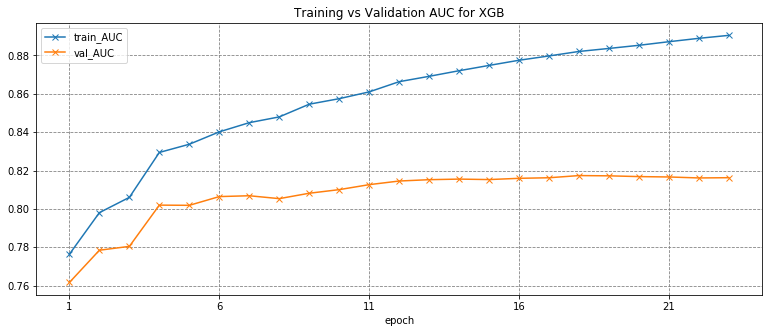

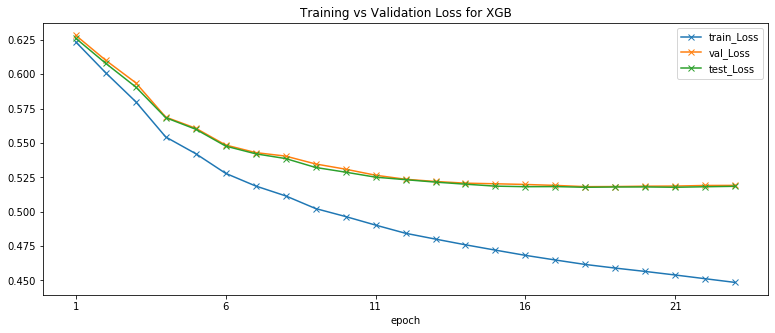

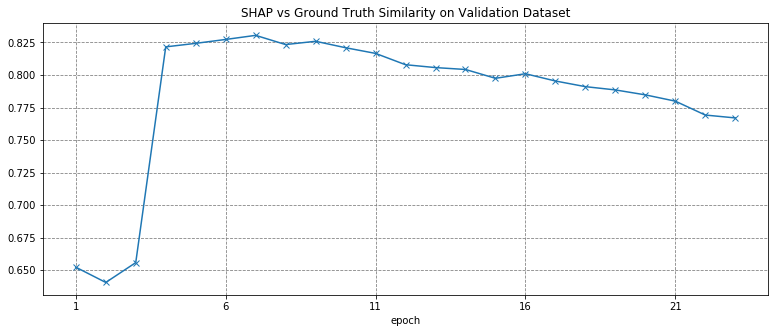

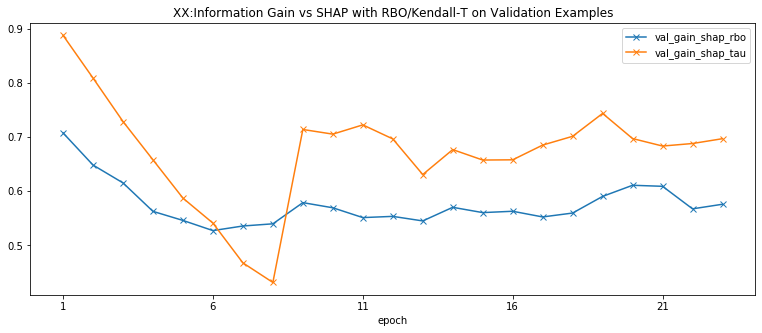

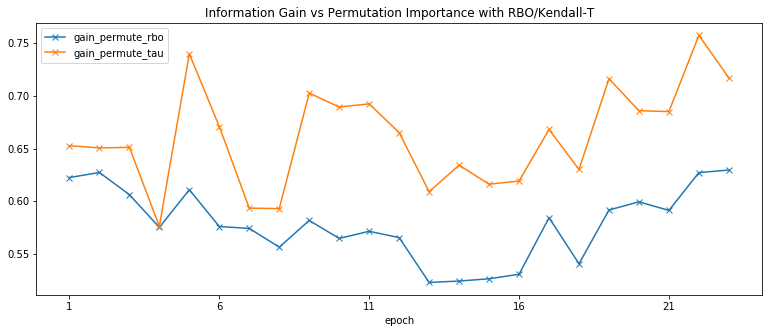

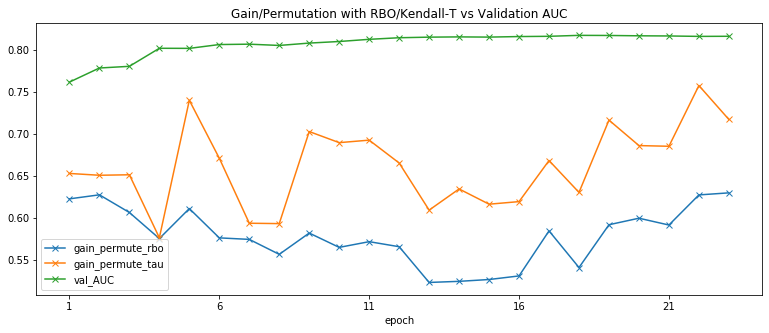

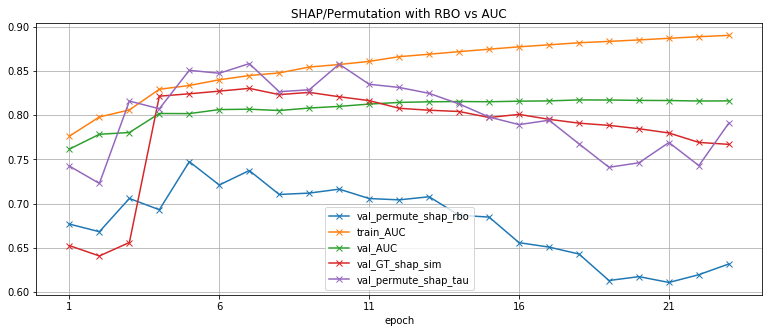

In [20]:
figsize = (13, 5)
df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["train_AUC", "val_AUC"],
    kind="line",
    marker="x",
)
plt.title("Training vs Validation AUC for XGB")
plt.grid(color='gray', linestyle='--')

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["train_Loss", "val_Loss", "test_Loss"],
    kind="line",
    marker="x",
)
plt.title("Training vs Validation Loss for XGB")

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["val_GT_shap_sim"],
    kind="line",
    marker="x",
    legend=False,
)
plt.title("SHAP vs Ground Truth Similarity on Validation Dataset")
plt.grid(color='gray', linestyle='--')


df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["val_gain_shap_rbo", "val_gain_shap_tau"],
    kind="line",
    marker="x",
)
plt.title("XX:Information Gain vs SHAP with RBO/Kendall-T on Validation Examples")

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["gain_permute_rbo", "gain_permute_tau"],
    kind="line",
    marker="x",
)
plt.title("Information Gain vs Permutation Importance with RBO/Kendall-T")

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["gain_permute_rbo", "gain_permute_tau", "val_AUC"],
    kind="line",
    marker="x",
)
plt.title("Gain/Permutation with RBO/Kendall-T vs Validation AUC")


df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["val_permute_shap_rbo", "train_AUC", "val_AUC", "val_GT_shap_sim", "val_permute_shap_tau"],
    kind="line",
    marker="x",
)
plt.title("SHAP/Permutation with RBO vs AUC")
plt.grid()
plt.show()

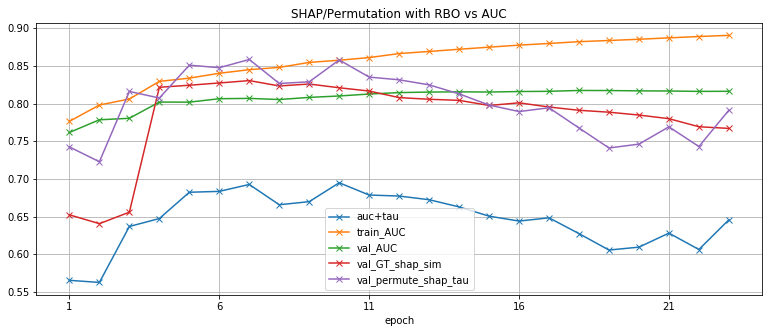

In [21]:
df_results['auc+tau'] = df_results['val_AUC'] * df_results['val_permute_shap_tau']
df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=['auc+tau', "train_AUC", "val_AUC", "val_GT_shap_sim", "val_permute_shap_tau"],
    kind="line",
    marker="x",
)
plt.title("SHAP/Permutation with RBO vs AUC")
plt.grid()
plt.show()

In [35]:
df_results

train_AUC   val_AUC  test_AUC  train_Loss  val_Loss  test_Loss  \
epoch                                                                   
1       0.776380  0.761651  0.766090    0.623523  0.628308   0.626123   
2       0.798055  0.778455  0.780365    0.601039  0.610143   0.607931   
3       0.806015  0.780456  0.784744    0.580052  0.593802   0.590751   
4       0.829427  0.801962  0.802104    0.554372  0.568832   0.568420   
5       0.833707  0.801860  0.803248    0.542239  0.560755   0.560002   
6       0.840165  0.806415  0.807320    0.527904  0.548528   0.547740   
7       0.844958  0.806854  0.808778    0.518715  0.543006   0.542131   
8       0.847958  0.805345  0.808431    0.511518  0.540453   0.538665   
9       0.854580  0.808160  0.812373    0.502300  0.534735   0.532193   
10      0.857462  0.810040  0.813447    0.496492  0.530933   0.528770   
11      0.861003  0.812636  0.815240    0.490266  0.526545   0.525139   
12      0.866321  0.814527  0.815966    0.484312  0.523605   0.523305   
13      0.869115  0.815228  0.816717    0.480068  0.521994   0.521525   
14      0.872041  0.815533  0.817321    0.475919  0.520766   0.520023   
15      0.874802  0.815287  0.818005    0.472035  0.520323   0.518599   
16      0.877497  0.815938  0.817905    0.468240  0.519818   0.518203   
17      0.879746  0.816235  0.817457    0.464863  0.519146   0.518275   
18      0.882081  0.817368  0.817725    0.461601  0.518226   0.517773   
19      0.883657  0.817236  0.817391    0.458975  0.518311   0.517986   
20      0.885292  0.816838  0.817324    0.456531  0.518563   0.518017   
21      0.887164  0.816641  0.817669    0.453949  0.518655   0.517793   
22      0.888932  0.816132  0.817401    0.451236  0.519089   0.518155   
23      0.890476  0.816265  0.817403    0.448535  0.519154   0.518486   

       gain_permute_rbo  gain_permute_tau  val_GT_shap_sim  test_GT_shap_sim  \
epoch                                                                          
1              0.622496          0.652767         0.652348          0.652148   
2              0.627299          0.650614         0.640643          0.641262   
3              0.606251          0.651199         0.655876          0.656710   
4              0.575182          0.576122         0.821595          0.820924   
5              0.610921          0.740002         0.824310          0.823933   
6              0.575989          0.670925         0.827300          0.826871   
7              0.574188          0.593450         0.830448          0.830933   
8              0.556364          0.592987         0.823367          0.823281   
9              0.581731          0.702707         0.825895          0.824552   
10             0.564670          0.689491         0.820943          0.819586   
11             0.571460          0.692471         0.816586          0.815652   
12             0.565454          0.665235         0.807890          0.807600   
13             0.522864          0.609080         0.805690          0.805781   
14             0.524186          0.634293         0.804238          0.804695   
15             0.526359          0.616139         0.797457          0.797286   
16             0.530641          0.619208         0.800962          0.800105   
17             0.584315          0.668171         0.795386          0.794476   
18             0.540645          0.630180         0.791048          0.790171   
19             0.591651          0.716336         0.788529          0.788086   
20             0.599426          0.685985         0.784738          0.784214   
21             0.591297          0.685166         0.779905          0.779067   
22             0.627193          0.757543         0.769233          0.768252   
23             0.629643          0.717116         0.767024          0.766090   

       val_gain_shap_rbo  val_gain_shap_tau  val_permute_shap_rbo  \
epoch                                                               
1               0.707612           0.88771

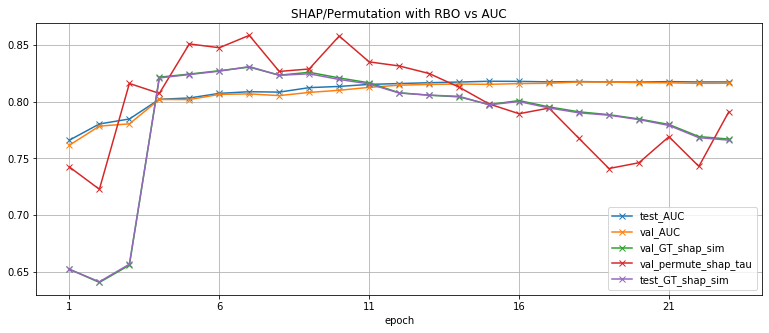

In [23]:
df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["test_AUC", "val_AUC", "val_GT_shap_sim", "val_permute_shap_tau", "test_GT_shap_sim"],
    kind="line",
    marker="x",
)
plt.title("SHAP/Permutation with RBO vs AUC")
plt.grid()
plt.show()

# Save figures

In [39]:
import seaborn as sns
plt.style.use('ggplot')

In [40]:
def ret_label_df(df, colname, dataset):
    len_epoch = df.shape[0]
    plot_df = df[['epoch', colname]].copy()
    plot_df.columns = ['epoch', 'AUC']
    plot_df['dataset'] = dataset
    
    return plot_df
    

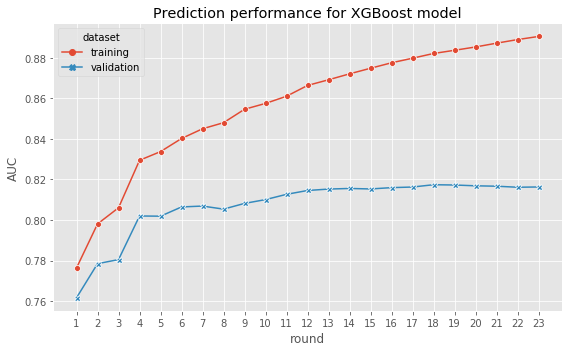

In [60]:
train_df = ret_label_df(df_results.reset_index(), 'train_AUC', 'training')
val_df = ret_label_df(df_results.reset_index(), 'val_AUC', 'validation')
plot_df = pd.concat([train_df, val_df])
plt.figure(figsize=(8, 5))
ax = sns.lineplot(
    data=plot_df, x="epoch", y="AUC", hue="dataset",
    markers=True, dashes=False, style='dataset')
ax.set_title("Prediction performance for XGBoost model")
ax.set_xlabel("round")
plt.tight_layout()
plt.savefig('./XGB_auc_vs_epoch.png', dpi=600)

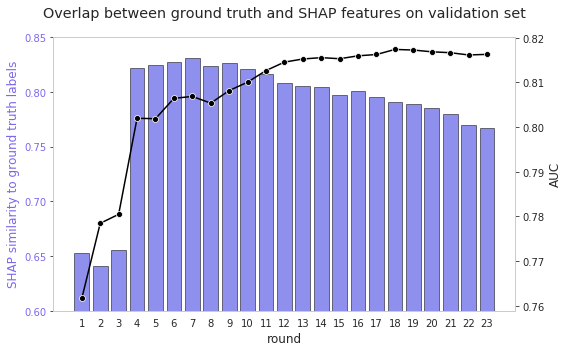

In [97]:
sns.set_style("whitegrid", {'axes.grid':False}) 
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=df_results.reset_index(), x="epoch", y="val_GT_shap_sim",
                 color='blue', alpha=0.5, edgecolor='black', linewidth=1)
ax.set(ylim=(0.6, 0.85))
ax.set_xlabel('round')
ax.set_ylabel('SHAP similarity to ground truth labels', color='mediumslateblue')
for i, label in enumerate(ax.get_yticklabels()):
    label.set_color("mediumslateblue")
ax2 = ax.twinx()
sns.lineplot(data=df_results.reset_index(), x="epoch", y="val_AUC", ax=ax2, 
             color='black', marker='o')
ax2.set_ylabel('AUC')
ax.set_title("Overlap between ground truth and SHAP features on validation set")
ax.title.set_position([.5, 1.05])
plt.tight_layout()
plt.savefig('./XGB_auc_vs_gt_SHAP.png', dpi=600)

In [98]:
df_results

train_AUC   val_AUC  test_AUC  train_Loss  val_Loss  test_Loss  \
epoch                                                                   
1       0.776380  0.761651  0.766090    0.623523  0.628308   0.626123   
2       0.798055  0.778455  0.780365    0.601039  0.610143   0.607931   
3       0.806015  0.780456  0.784744    0.580052  0.593802   0.590751   
4       0.829427  0.801962  0.802104    0.554372  0.568832   0.568420   
5       0.833707  0.801860  0.803248    0.542239  0.560755   0.560002   
6       0.840165  0.806415  0.807320    0.527904  0.548528   0.547740   
7       0.844958  0.806854  0.808778    0.518715  0.543006   0.542131   
8       0.847958  0.805345  0.808431    0.511518  0.540453   0.538665   
9       0.854580  0.808160  0.812373    0.502300  0.534735   0.532193   
10      0.857462  0.810040  0.813447    0.496492  0.530933   0.528770   
11      0.861003  0.812636  0.815240    0.490266  0.526545   0.525139   
12      0.866321  0.814527  0.815966    0.484312  0.523605   0.523305   
13      0.869115  0.815228  0.816717    0.480068  0.521994   0.521525   
14      0.872041  0.815533  0.817321    0.475919  0.520766   0.520023   
15      0.874802  0.815287  0.818005    0.472035  0.520323   0.518599   
16      0.877497  0.815938  0.817905    0.468240  0.519818   0.518203   
17      0.879746  0.816235  0.817457    0.464863  0.519146   0.518275   
18      0.882081  0.817368  0.817725    0.461601  0.518226   0.517773   
19      0.883657  0.817236  0.817391    0.458975  0.518311   0.517986   
20      0.885292  0.816838  0.817324    0.456531  0.518563   0.518017   
21      0.887164  0.816641  0.817669    0.453949  0.518655   0.517793   
22      0.888932  0.816132  0.817401    0.451236  0.519089   0.518155   
23      0.890476  0.816265  0.817403    0.448535  0.519154   0.518486   

       gain_permute_rbo  gain_permute_tau  val_GT_shap_sim  test_GT_shap_sim  \
epoch                                                                          
1              0.622496          0.652767         0.652348          0.652148   
2              0.627299          0.650614         0.640643          0.641262   
3              0.606251          0.651199         0.655876          0.656710   
4              0.575182          0.576122         0.821595          0.820924   
5              0.610921          0.740002         0.824310          0.823933   
6              0.575989          0.670925         0.827300          0.826871   
7              0.574188          0.593450         0.830448          0.830933   
8              0.556364          0.592987         0.823367          0.823281   
9              0.581731          0.702707         0.825895          0.824552   
10             0.564670          0.689491         0.820943          0.819586   
11             0.571460          0.692471         0.816586          0.815652   
12             0.565454          0.665235         0.807890          0.807600   
13             0.522864          0.609080         0.805690          0.805781   
14             0.524186          0.634293         0.804238          0.804695   
15             0.526359          0.616139         0.797457          0.797286   
16             0.530641          0.619208         0.800962          0.800105   
17             0.584315          0.668171         0.795386          0.794476   
18             0.540645          0.630180         0.791048          0.790171   
19             0.591651          0.716336         0.788529          0.788086   
20             0.599426          0.685985         0.784738          0.784214   
21             0.591297          0.685166         0.779905          0.779067   
22             0.627193          0.757543         0.769233          0.768252   
23             0.629643          0.717116         0.767024          0.766090   

       val_gain_shap_rbo  val_gain_shap_tau  val_permute_shap_rbo  \
epoch                                                               
1               0.707612           0.88771

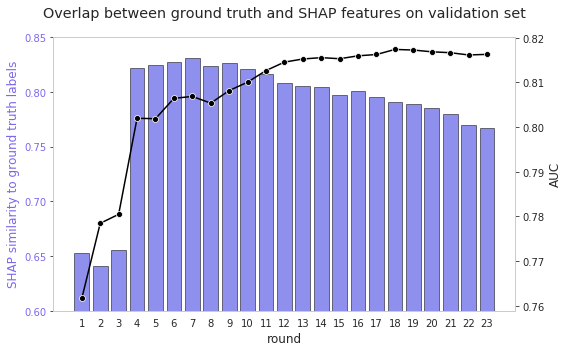

In [301]:
sns.set_style("whitegrid", {'axes.grid':False}) 
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=df_results.reset_index(), x="epoch", y="val_GT_shap_sim",
                 color='blue', alpha=0.5, edgecolor='black', linewidth=1)
ax.set(ylim=(0.6, 0.85))
ax.set_xlabel('round')
ax.set_ylabel('SHAP similarity to ground truth labels', color='mediumslateblue')
for i, label in enumerate(ax.get_yticklabels()):
    label.set_color("mediumslateblue")
ax2 = ax.twinx()
sns.lineplot(data=df_results.reset_index(), x="epoch", y="val_AUC", ax=ax2, 
             color='black', marker='o')
ax2.set_ylabel('AUC')
ax.set_title("Overlap between ground truth and SHAP features on validation set")
ax.title.set_position([.5, 1.05])
plt.tight_layout()
plt.savefig('./XGB_auc_vs_gt_SHAP_val.png', dpi=600)

In [101]:
100 * (0.830448 - 0.791048) / 0.791048

4.980734418138974

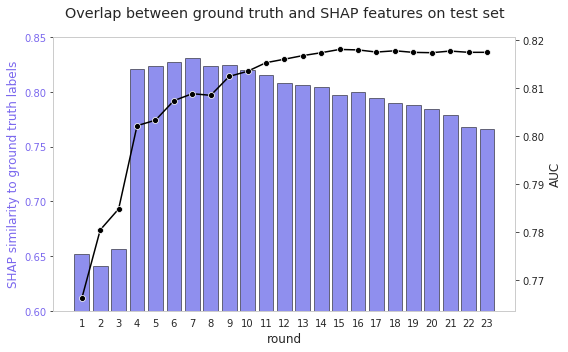

In [302]:
sns.set_style("whitegrid", {'axes.grid':False}) 
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=df_results.reset_index(), x="epoch", y="test_GT_shap_sim",
                 color='blue', alpha=0.5, edgecolor='black', linewidth=1)
ax.set(ylim=(0.6, 0.85))
ax.set_xlabel('round')
ax.set_ylabel('SHAP similarity to ground truth labels', color='mediumslateblue')
for i, label in enumerate(ax.get_yticklabels()):
    label.set_color("mediumslateblue")
ax2 = ax.twinx()
sns.lineplot(data=df_results.reset_index(), x="epoch", y="test_AUC", ax=ax2, 
             color='black', marker='o')
ax2.set_ylabel('AUC')
ax.set_title("Overlap between ground truth and SHAP features on test set")
ax.title.set_position([.5, 1.05])
plt.tight_layout()
plt.savefig('./XGB_auc_vs_gt_SHAP_test.png', dpi=600)

In [101]:
100 * (0.830448 - 0.791048) / 0.791048

4.980734418138974

# Visualize SHAP

In [102]:
shap_path

'./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/test_shap_21.pkl'

In [103]:
new_path = './output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_8.pkl'

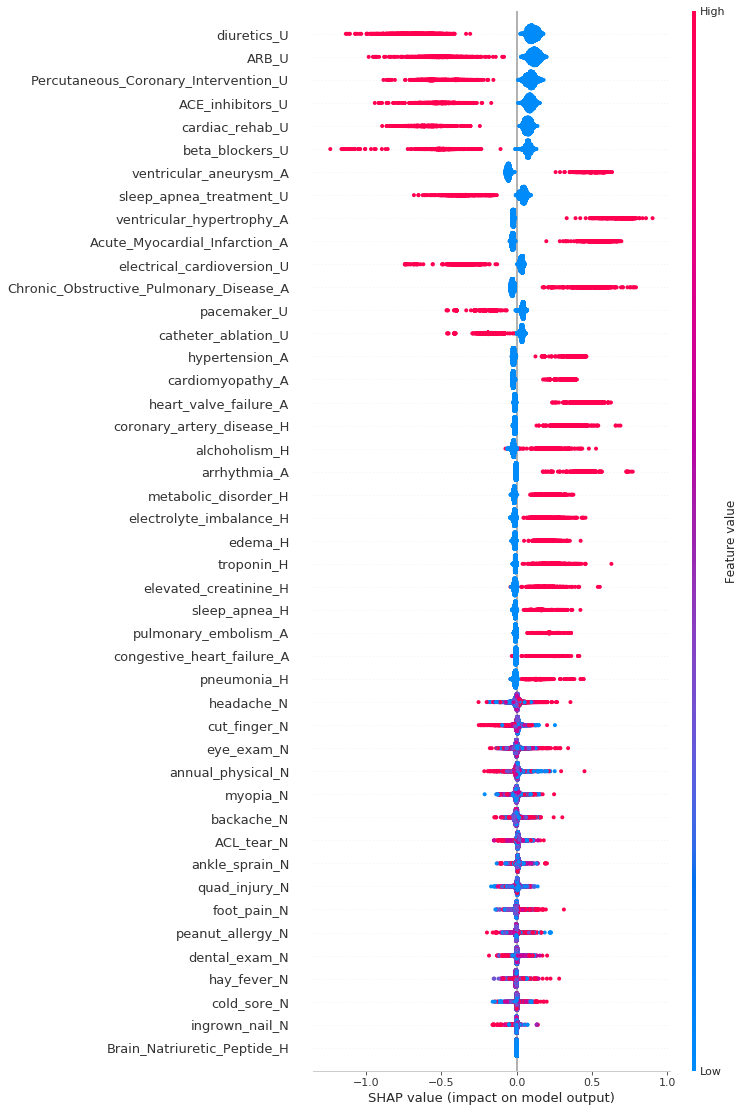

In [104]:
def get_shap_values_and_features_xgb(all_shap):
    all_features = []
    all_scores = []
    for pat_id, shap_info in all_shap.items():
        if not all_features:
            all_features = shap_info['features_xgb']
        all_scores.append(shap_info['xgb_shap'])
    all_scores = np.array(all_scores)    
    return all_features, all_scores
with open(new_path, 'rb') as fp:
    all_shap = pickle.load(fp)
features, shap_values = get_shap_values_and_features_xgb(all_shap)
val_plot_df = pd.read_csv(x_valid_one_hot_path)
#For summary plot
shap.summary_plot(shap_values, val_plot_df[features], feature_names=features, max_display=len(features))
#Global Feature importance
#shap.summary_plot(shap_values, features=features, plot_type="bar")

In [105]:
new_path = './output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_11.pkl'

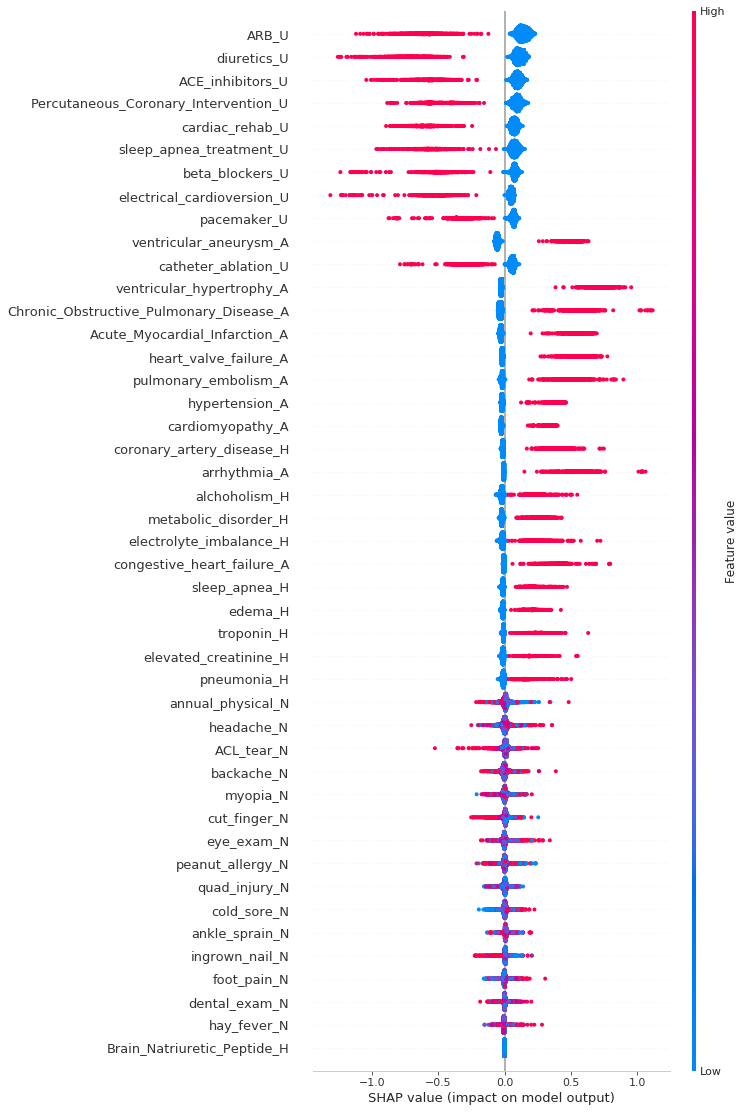

In [106]:
def get_shap_values_and_features_xgb(all_shap):
    all_features = []
    all_scores = []
    for pat_id, shap_info in all_shap.items():
        if not all_features:
            all_features = shap_info['features_xgb']
        all_scores.append(shap_info['xgb_shap'])
    all_scores = np.array(all_scores)    
    return all_features, all_scores
with open(new_path, 'rb') as fp:
    all_shap = pickle.load(fp)
features, shap_values = get_shap_values_and_features_xgb(all_shap)
val_plot_df = pd.read_csv(x_valid_one_hot_path)
#For summary plot
shap.summary_plot(shap_values, val_plot_df[features], feature_names=features, max_display=len(features))
#Global Feature importance
#shap.summary_plot(shap_values, features=features, plot_type="bar")

In [110]:
new_path = './output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_18.pkl'

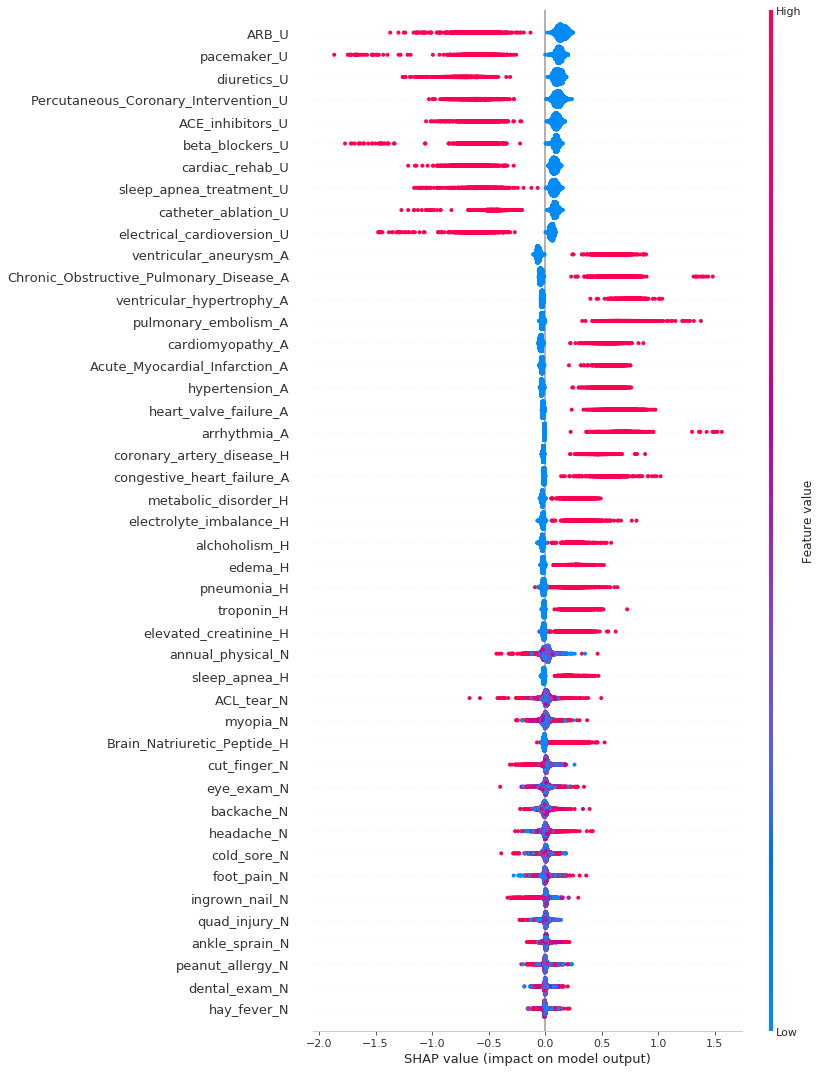

In [225]:
def get_shap_values_and_features_xgb(all_shap):
    all_features = []
    all_scores = []
    for pat_id, shap_info in all_shap.items():
        if not all_features:
            all_features = shap_info['features_xgb']
        all_scores.append(shap_info['xgb_shap'])
    all_scores = np.array(all_scores)    
    return all_features, all_scores
with open(new_path, 'rb') as fp:
    all_shap = pickle.load(fp)
features, shap_values = get_shap_values_and_features_xgb(all_shap)
val_plot_df = pd.read_csv(x_valid_one_hot_path)
#For summary plot

shap.summary_plot(shap_values, val_plot_df[features], feature_names=features, 
                  max_display=len(features), show=False)
fig = plt.gcf()
#Global Feature importance
#shap.summary_plot(shap_values, features=features, plot_type="bar")
fig.set_size_inches(12, 15)
plt.tight_layout()
plt.savefig("./SHAP_XGB_Round18_global.png", dpi=600)

## Plot similarity between global SHAP vs Information Gain

In [275]:
epochs = range(1, len(model_paths) + 1)
figsize = (8, 8)

rbo_corr = []
tau_corr = []
for epoch in [18]:
    shap_path = shap_save_path_pattern.format("val", epoch)
    mod_path = model_save_path.format(epoch)
    xgb_model = sj_utils.load_pickle(mod_path)  
    val_results = sj_utils.load_pickle(shap_path)    
    print(f"shap: {shap_path}")
    print(f"xgb: {mod_path}")
    xgb_gain = pd.DataFrame(
            (xgb_model.get_score(importance_type="gain")).items()
        )
    xgb_gain.columns = ["features", "xgb_gain"]
    xgb_gain['xgb_gain_rank'] = xgb_gain['xgb_gain'].rank(ascending=False)
    
    df_shap = get_features_and_global_shap(val_results)
    df_shap.rename(columns={'scores': 'shap_scores'}, inplace=True)
    df_shap['shap_rank'] = df_shap['shap_scores'].rank(ascending=False)
    
    gain_shap_df = xgb_gain[['features', 'xgb_gain', 'xgb_gain_rank']].merge(
        df_shap[['features', 'shap_scores', 'shap_rank']], how='inner', on='features')
    
    rbo_score = rbo.RankingSimilarity(
        gain_shap_df.xgb_gain_rank.values, gain_shap_df.shap_rank.values).rbo(
            p=p_rbo
        )
    rbo_corr.append(rbo_score)

    tau_score = get_wtau(gain_shap_df.xgb_gain, gain_shap_df.shap_scores)
    tau_corr.append(tau_score)

shap: ./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_18.pkl
xgb: ./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/models/model_18.pkl


In [278]:
gain_shap_df.head()

features   xgb_gain  xgb_gain_rank  shap_scores  shap_rank
0             diuretics_U  61.684111            7.0     0.170569        3.0
1          hypertension_A  87.316533            2.0     0.067217       17.0
2            arrhythmia_A  28.896881           16.0     0.055901       19.0
3  ventricular_aneurysm_A  37.608803           13.0     0.097946       11.0
4   heart_valve_failure_A  39.165147           10.0     0.063537       18.0

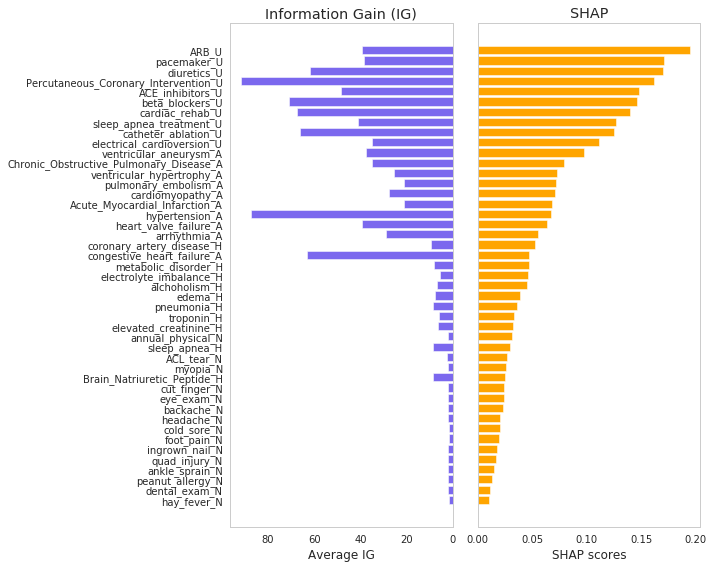

In [298]:
gain_shap_df.sort_values('shap_scores', ascending=True, inplace=True)

fig = plt.figure(figsize=(10, 8))
axes = fig.subplots(ncols=2, sharey=True)
#        row.bar(
#            df['features'], df[epoch_col], 0.8, label=epoch_col, color=color, edgecolor='black')
axes[0].barh(
    gain_shap_df.features, gain_shap_df.xgb_gain, color='mediumslateblue',
    align='center', zorder=10)
axes[0].set(title='Information Gain (IG)', xlabel="Average IG")
axes[1].barh(
    gain_shap_df.features, gain_shap_df.shap_scores, color='orange',
    align='center')
axes[1].set(title='SHAP', xlabel="SHAP scores")
axes[0].invert_xaxis()
#axes[1].set_yticks([])
fig.subplots_adjust(wspace=0.09)
plt.tight_layout()
plt.savefig("XGBoost_IG_SHAP_R18.png", dpi=600)

shap: ./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_1.pkl
xgb: ./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/models/model_1.pkl
shap: ./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_2.pkl
xgb: ./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/models/model_2.pkl
shap: ./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_3.pkl
xgb: ./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/models/model_3.pkl
shap: ./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_4.pkl
xgb: ./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/models/model_4.pkl
shap: ./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_5.pkl
xgb: ./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/models/model_5.pkl
shap: ./ou

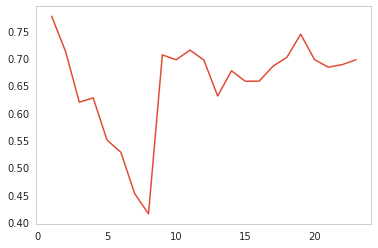

In [299]:
rbo_corr = []
tau_corr = []
for epoch in epochs:
    shap_path = shap_save_path_pattern.format("val", epoch)
    mod_path = model_save_path.format(epoch)
    xgb_model = sj_utils.load_pickle(mod_path)  
    val_results = sj_utils.load_pickle(shap_path)    
    print(f"shap: {shap_path}")
    print(f"xgb: {mod_path}")
    xgb_gain = pd.DataFrame(
            (xgb_model.get_score(importance_type="gain")).items()
        )
    xgb_gain.columns = ["features", "xgb_gain"]
    xgb_gain['xgb_gain_rank'] = xgb_gain['xgb_gain'].rank(ascending=False)
    
    df_shap = get_features_and_global_shap(val_results)
    df_shap.rename(columns={'scores': 'shap_scores'}, inplace=True)
    df_shap['shap_rank'] = df_shap['shap_scores'].rank(ascending=False)
    
    gain_shap_df = xgb_gain[['features', 'xgb_gain', 'xgb_gain_rank']].merge(
        df_shap[['features', 'shap_scores', 'shap_rank']], how='inner', on='features')
    
    rbo_score = rbo.RankingSimilarity(
        gain_shap_df.xgb_gain_rank.values, gain_shap_df.shap_rank.values).rbo(
            p=p_rbo
        )
    rbo_corr.append(rbo_score)

    tau_score = get_wtau(gain_shap_df.xgb_gain, gain_shap_df.shap_scores)
    tau_corr.append(tau_score)
    
plt.plot(epochs, tau_corr)

In [300]:
tau_corr

[0.7763891909535975,
 0.7123525948628957,
 0.6193973523048518,
 0.6272825729055652,
 0.5502923029567581,
 0.5279650089196151,
 0.45247359132315357,
 0.41531217057905767,
 0.7057804701547155,
 0.6969380817410713,
 0.7145156333698359,
 0.6964988350749315,
 0.6307395771622627,
 0.6767596044559847,
 0.657503786430521,
 0.6579001685208404,
 0.6851017323362347,
 0.7013409404062074,
 0.7435562643261069,
 0.6971391006508987,
 0.683331316636005,
 0.6880113236582086,
 0.69691896848165]

# Distribution of similarities

In [360]:
valpath = './output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_18.pkl'
testpath = './output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/test_shap_18.pkl'

In [361]:
with open(valpath, 'rb') as fp:
    all_shap = pickle.load(fp)
val_features, val_shap_values = get_shap_values_and_features_xgb(all_shap)

with open(testpath, 'rb') as fp:
    all_shap = pickle.load(fp)
tst_features, tst_shap_values = get_shap_values_and_features_xgb(all_shap)

In [362]:
avg_sim, val_sim = get_model_intersection_similarity_v2(
    ([val_features]*len(val_shap_values), val_shap_values), absolute=True
)

avg_sim, tst_sim = get_model_intersection_similarity_v2(
    ([tst_features]*len(tst_shap_values), tst_shap_values), absolute=True
)

In [363]:
pd.DataFrame(val_sim).describe()

0
count  7000.000000
mean      0.791048
std       0.051318
min       0.566667
25%       0.766667
50%       0.800000
75%       0.833333
max       0.966667

In [364]:
pd.DataFrame(tst_sim).describe()

0
count  7000.000000
mean      0.790171
std       0.051556
min       0.566667
25%       0.766667
50%       0.800000
75%       0.833333
max       0.933333

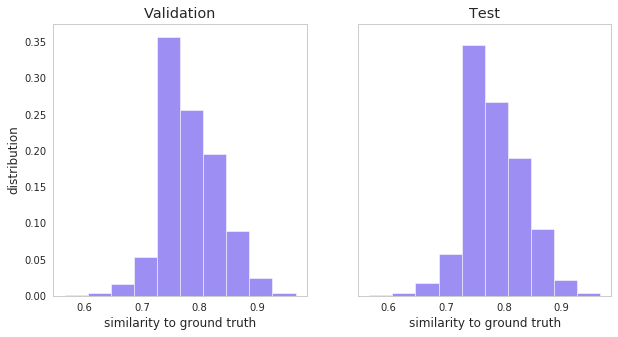

In [385]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(10, 5))
sns.histplot(val_sim, ax=ax1, binwidth=0.04, color='mediumslateblue', stat='probability')
ax1.set_xlabel("similarity to ground truth")
ax1.set_title("Validation")
ax1.set_ylabel("distribution")
sns.histplot(tst_sim, ax=ax2, binwidth=0.04, color='mediumslateblue', stat='probability')
ax2.set_xlabel("similarity to ground truth")
ax2.set_title("Test")
plt.savefig("XGB_sim_dist.png", dpi=600)

## Plot Global Importance per Epoch

./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_1.pkl


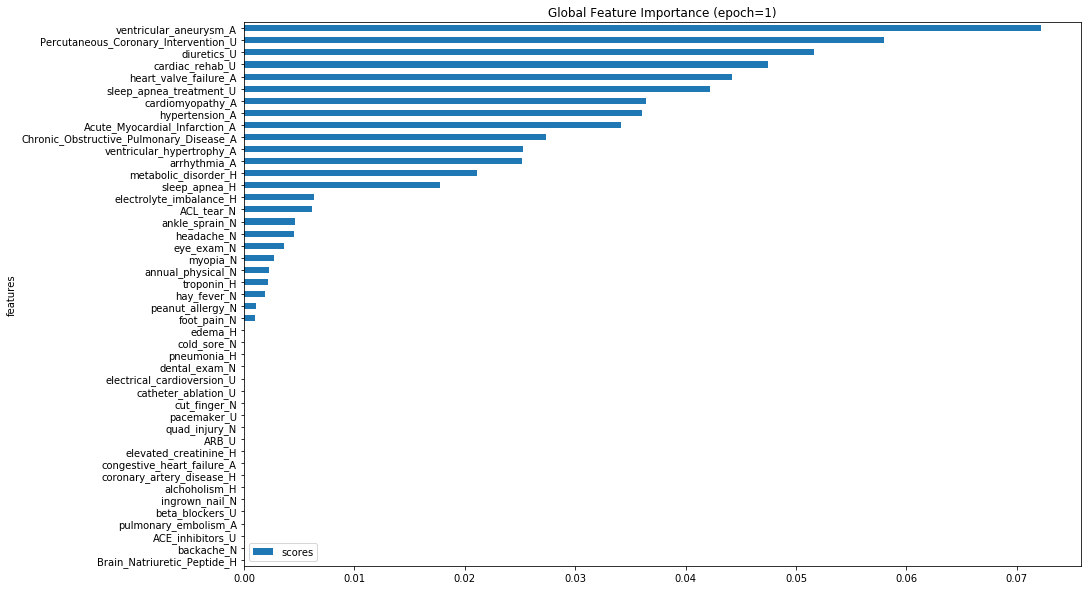

./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_2.pkl


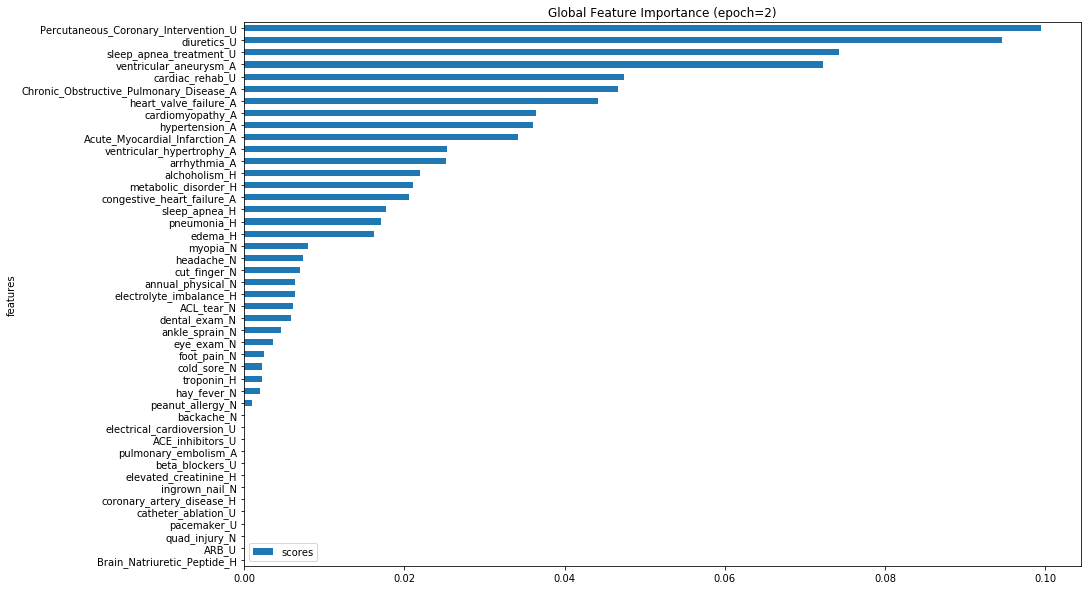

./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_3.pkl


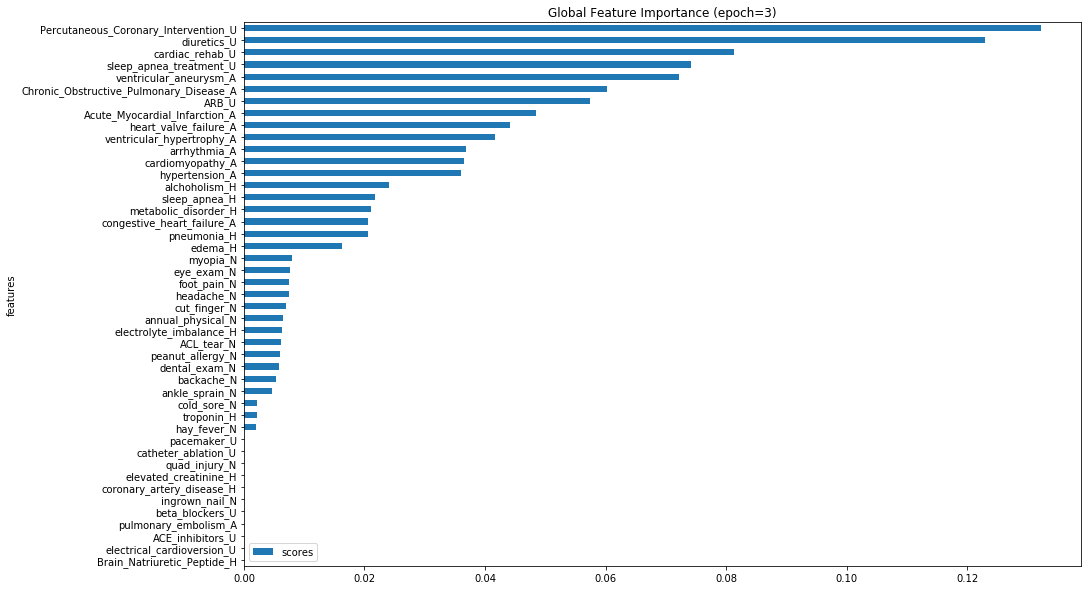

./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_4.pkl


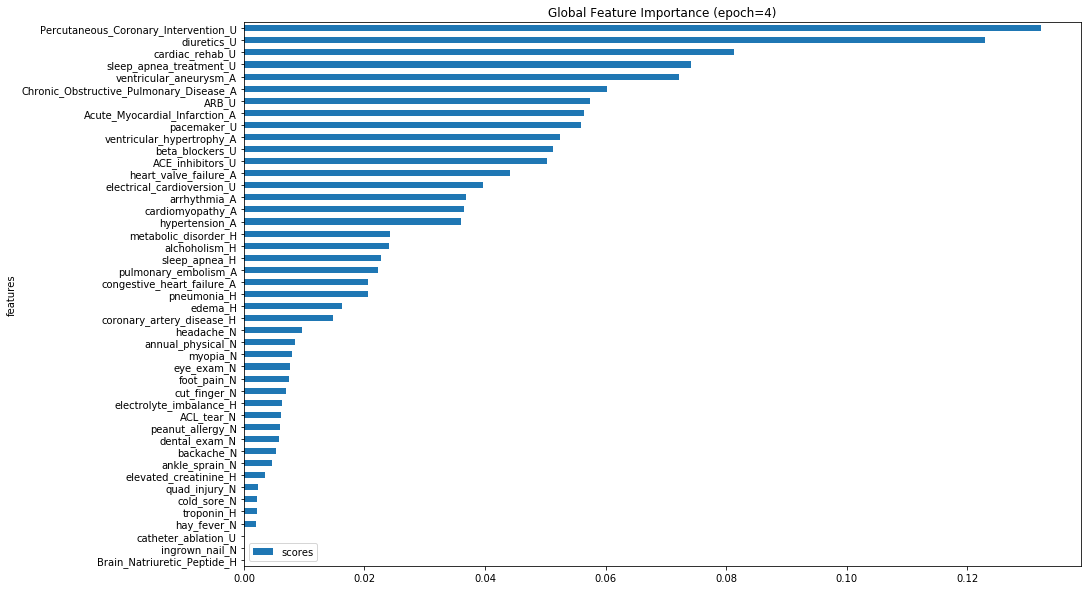

./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_5.pkl


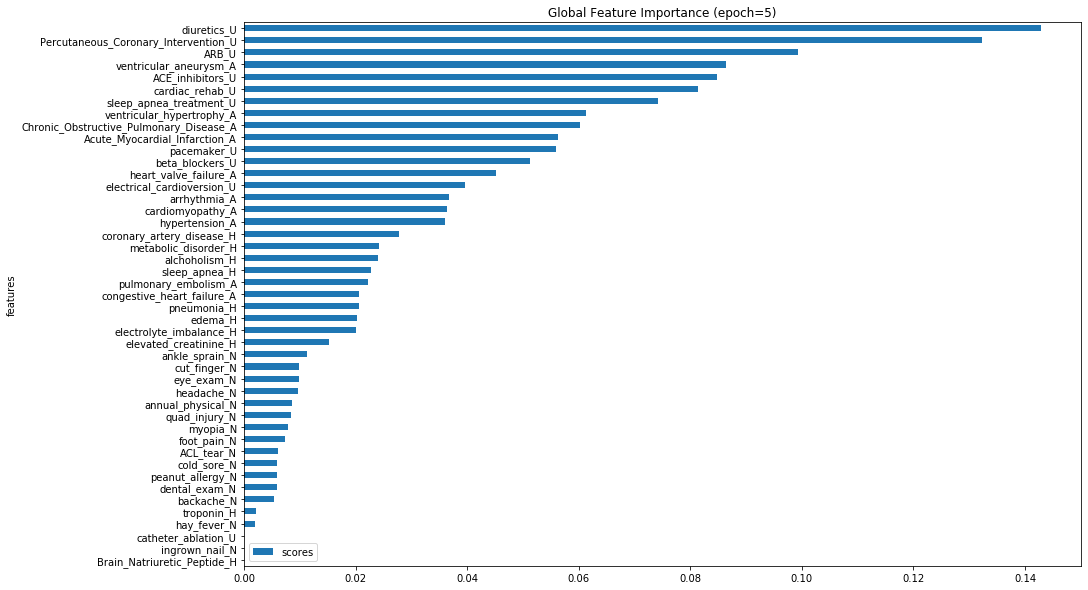

./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_6.pkl


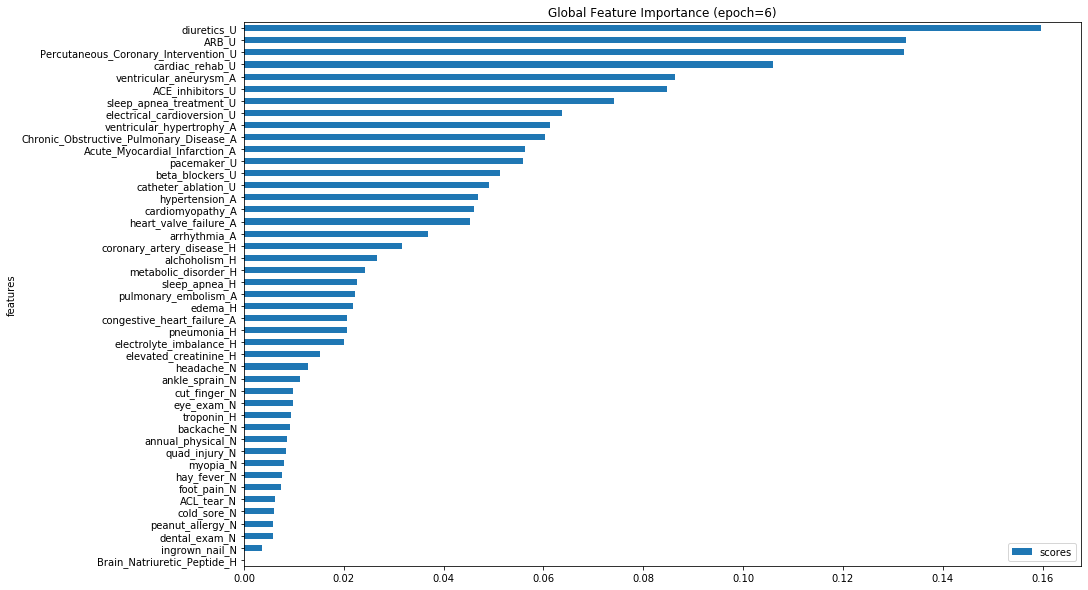

./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_7.pkl


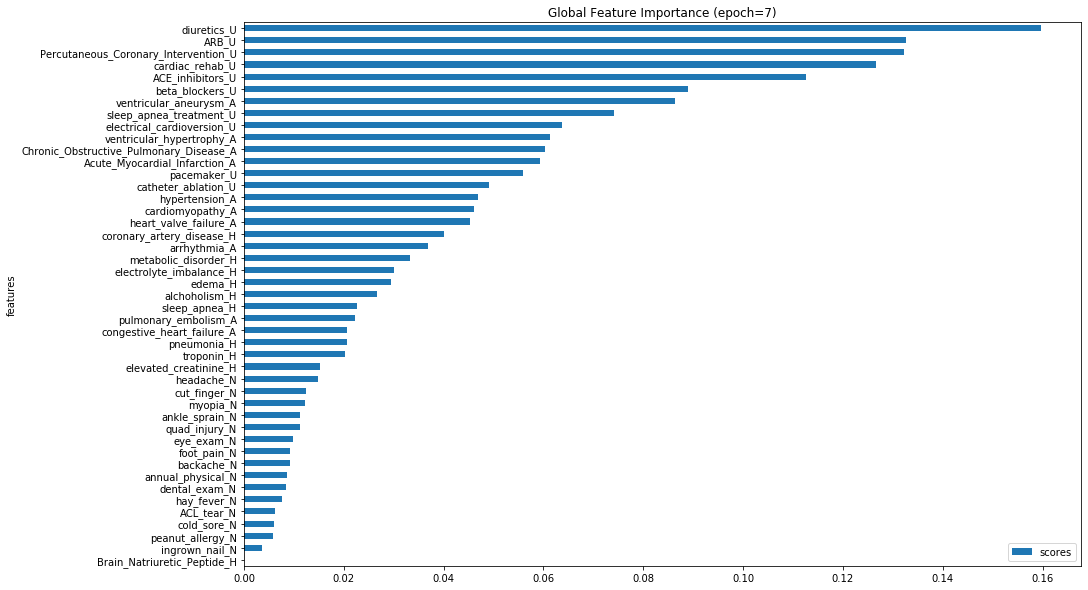

./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_8.pkl


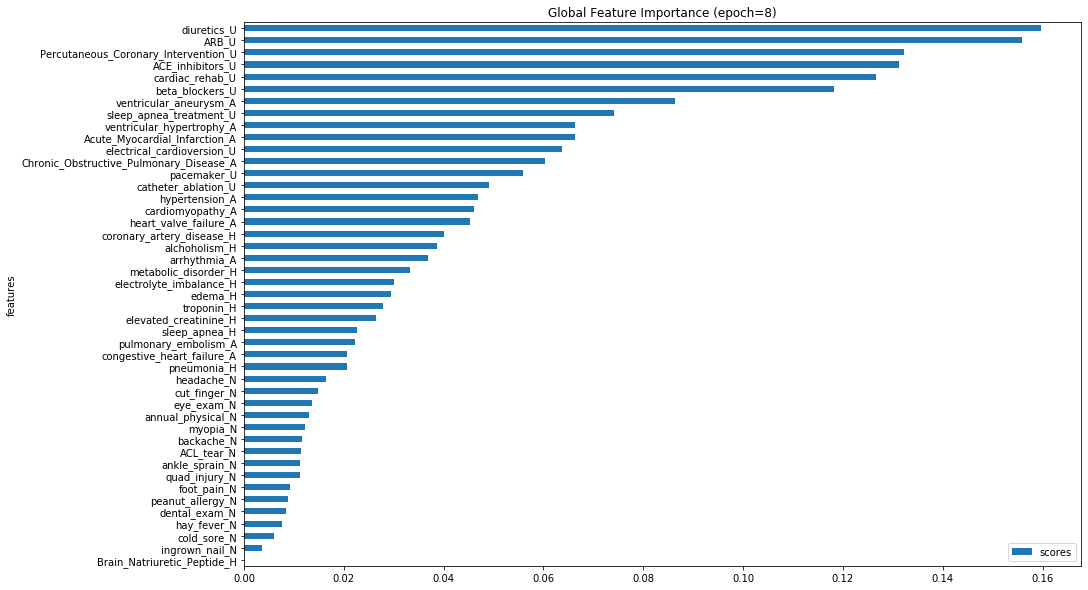

./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_9.pkl


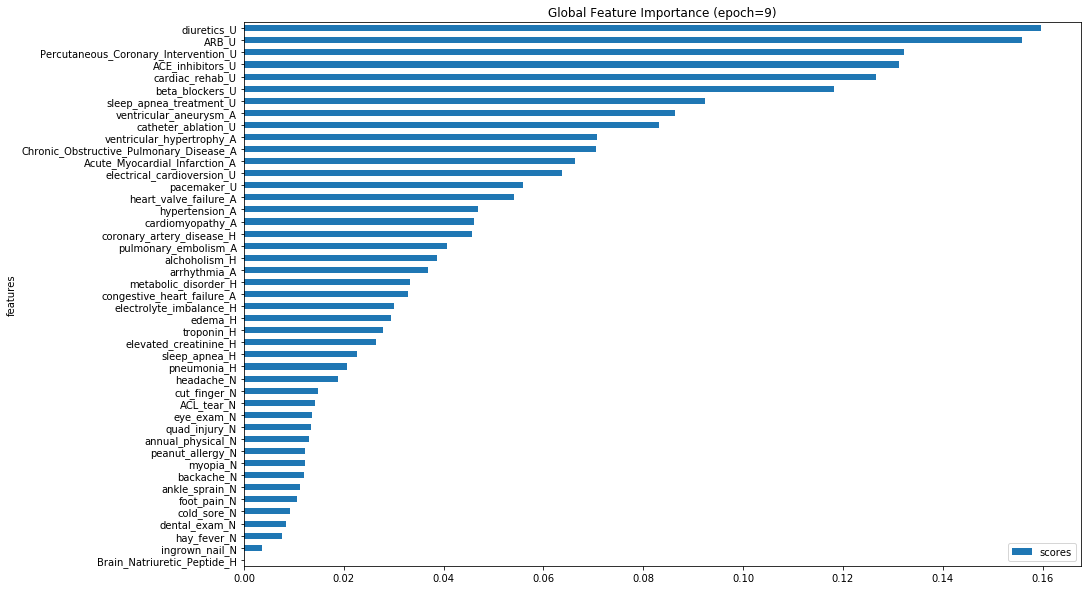

./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_10.pkl


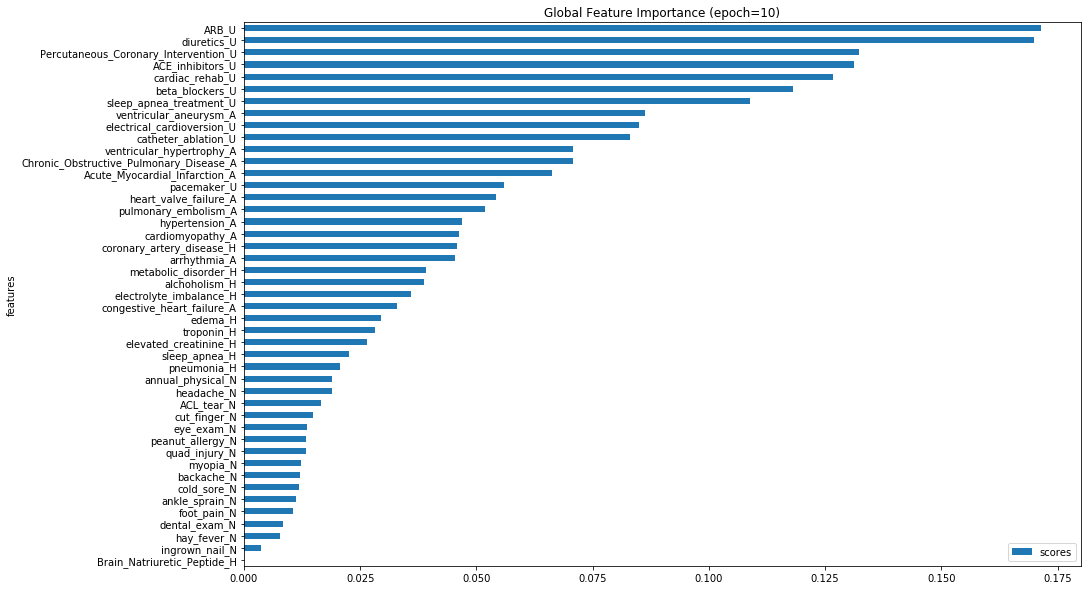

./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_11.pkl


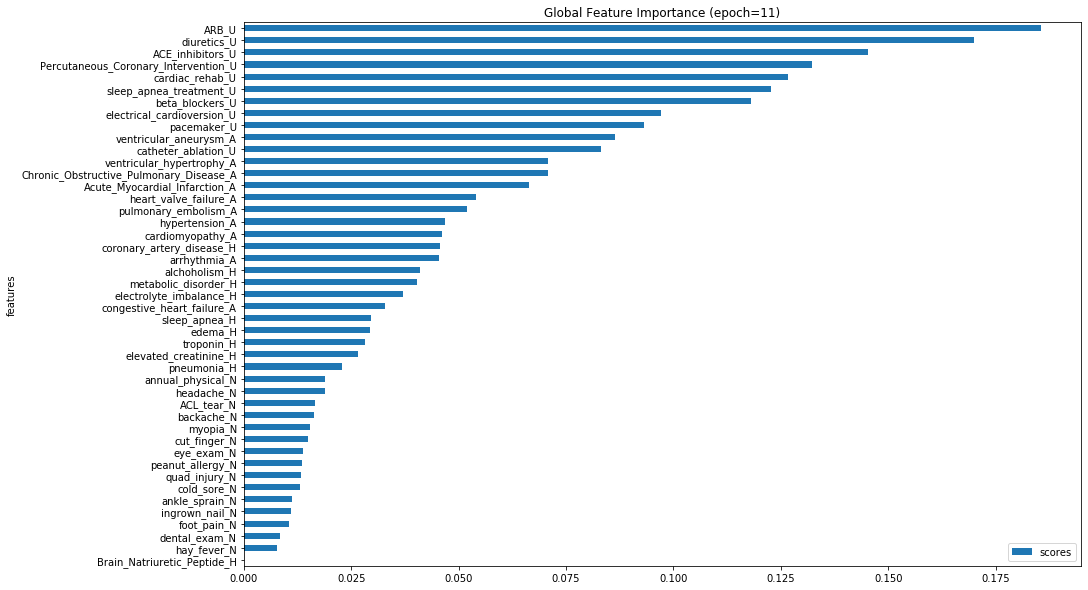

./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_12.pkl


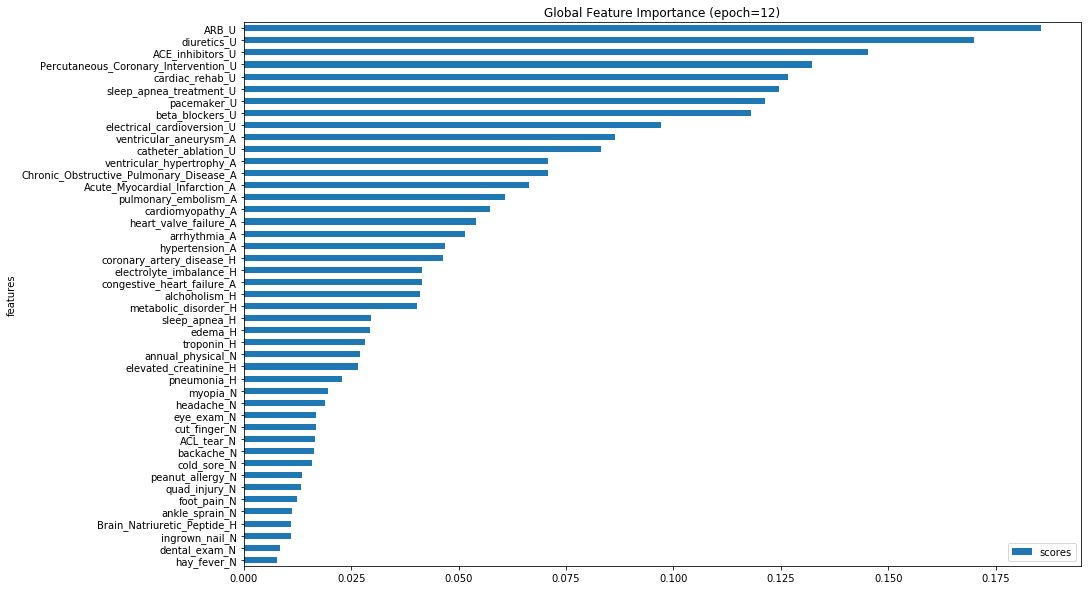

./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_13.pkl


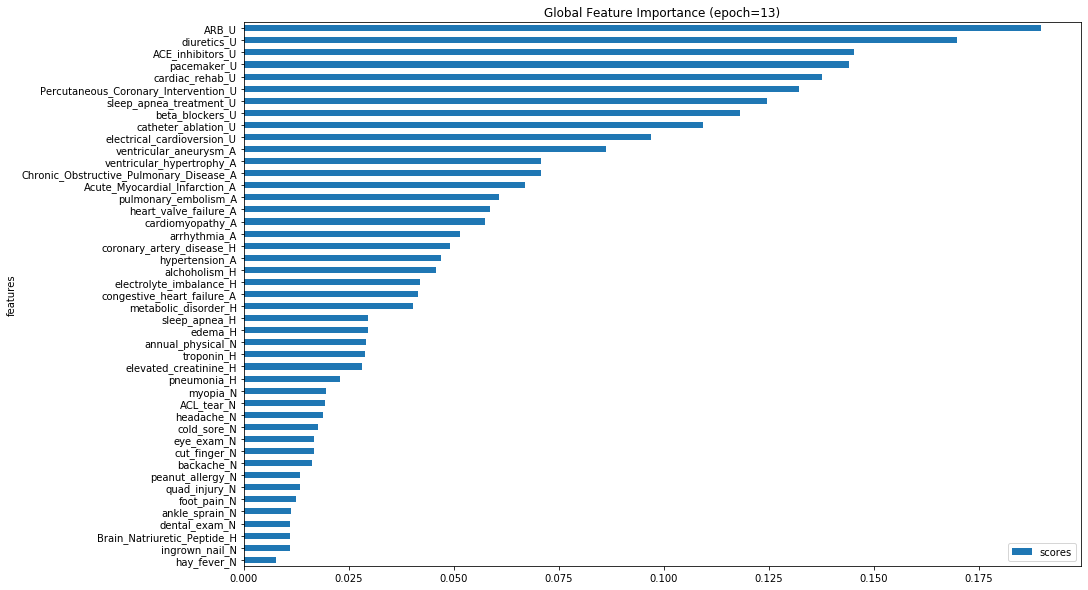

./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_14.pkl


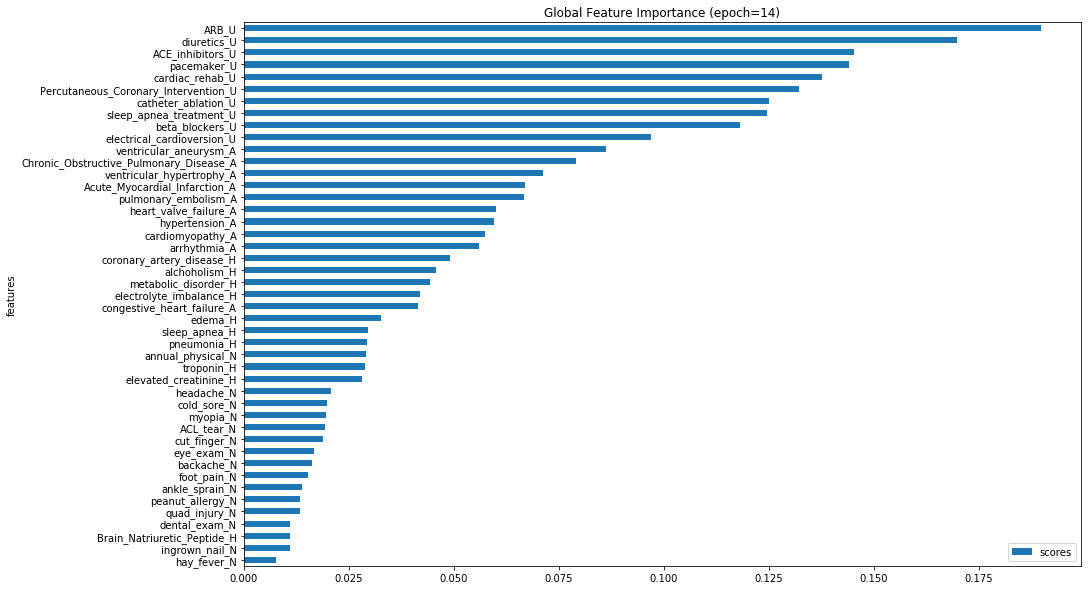

./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_15.pkl


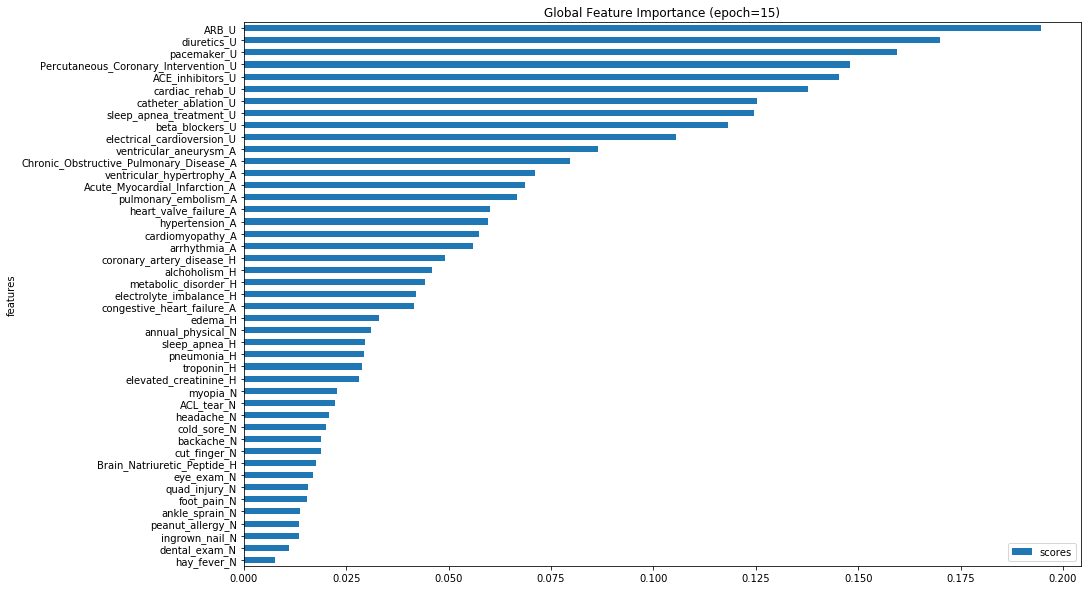

./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_16.pkl


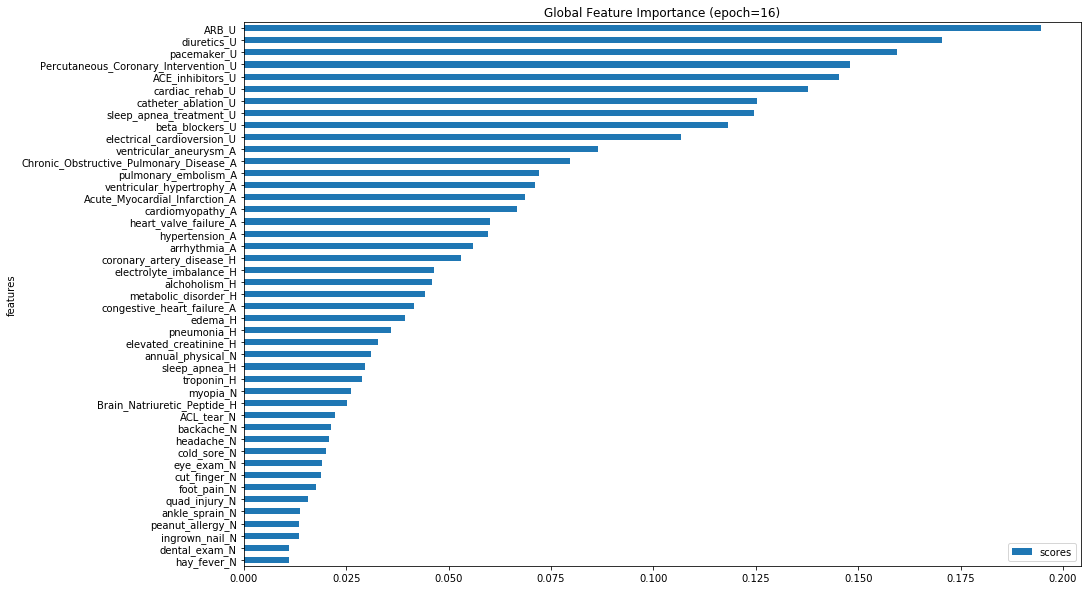

./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_17.pkl


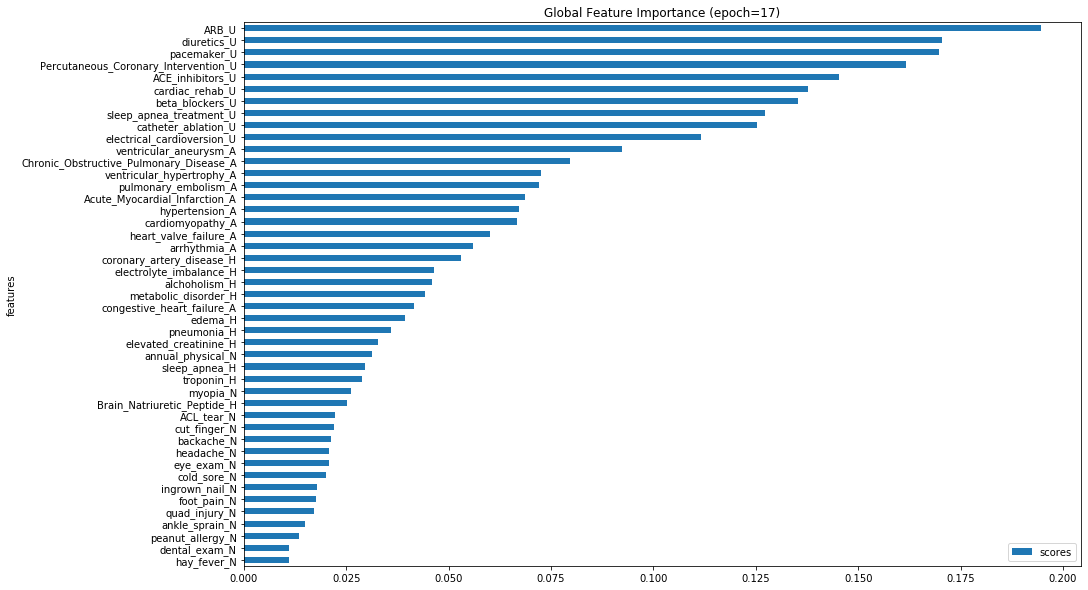

./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_18.pkl


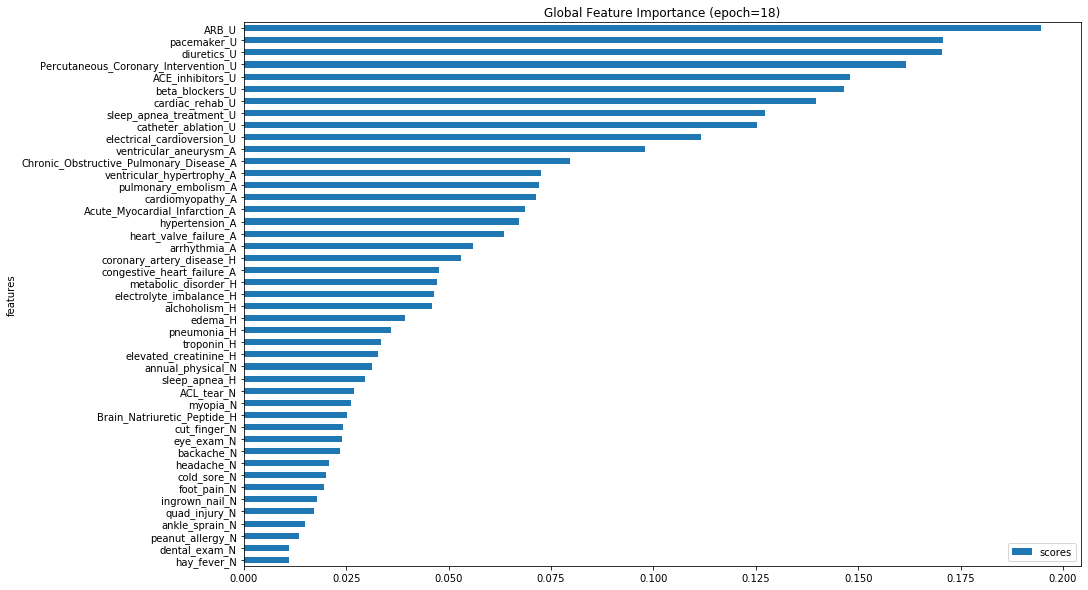

./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_19.pkl


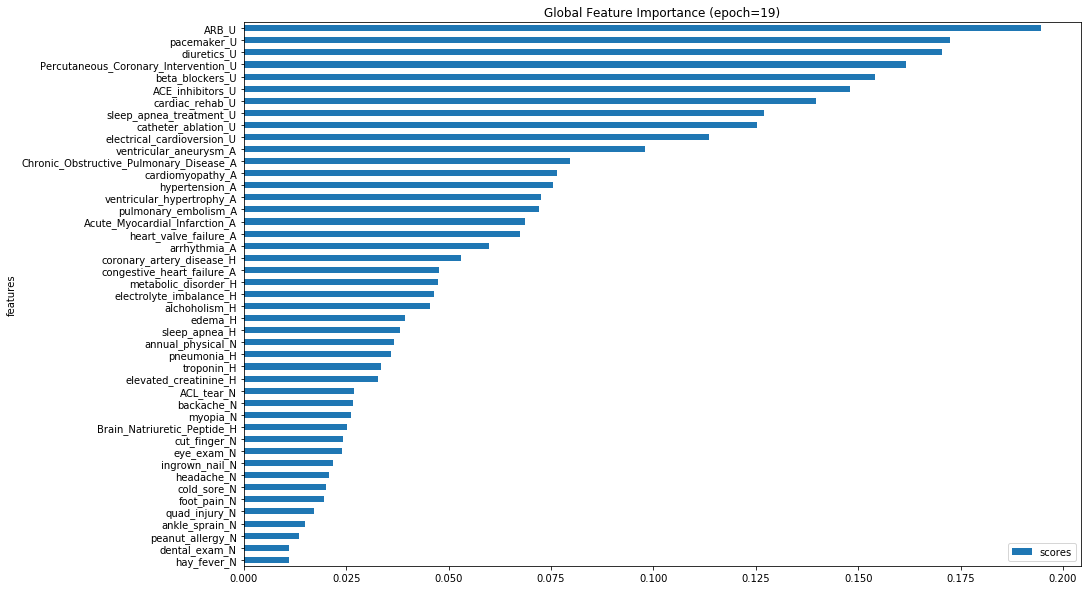

./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_20.pkl


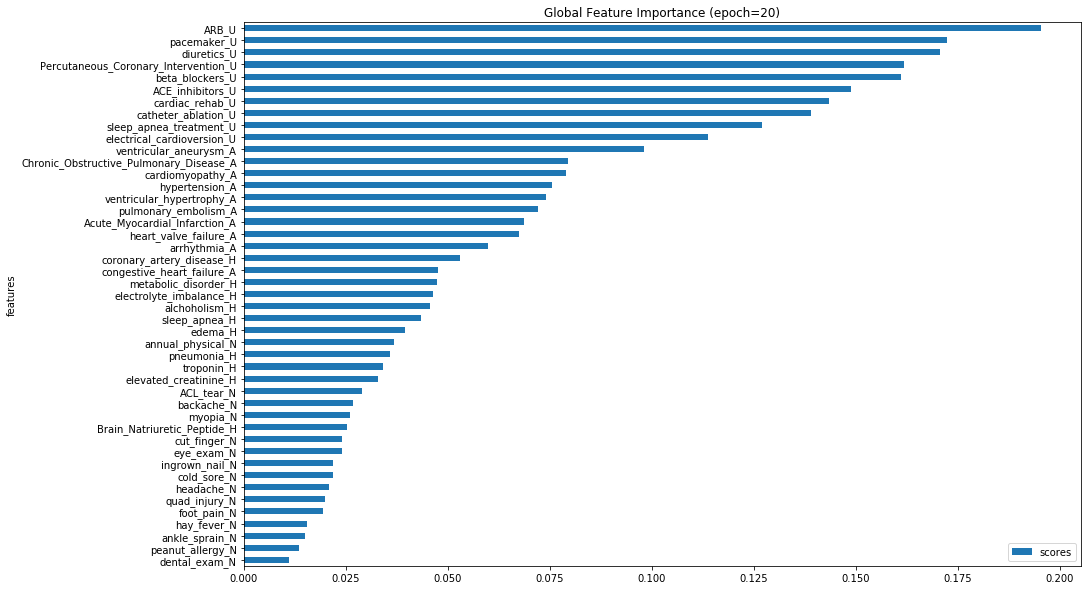

./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_21.pkl


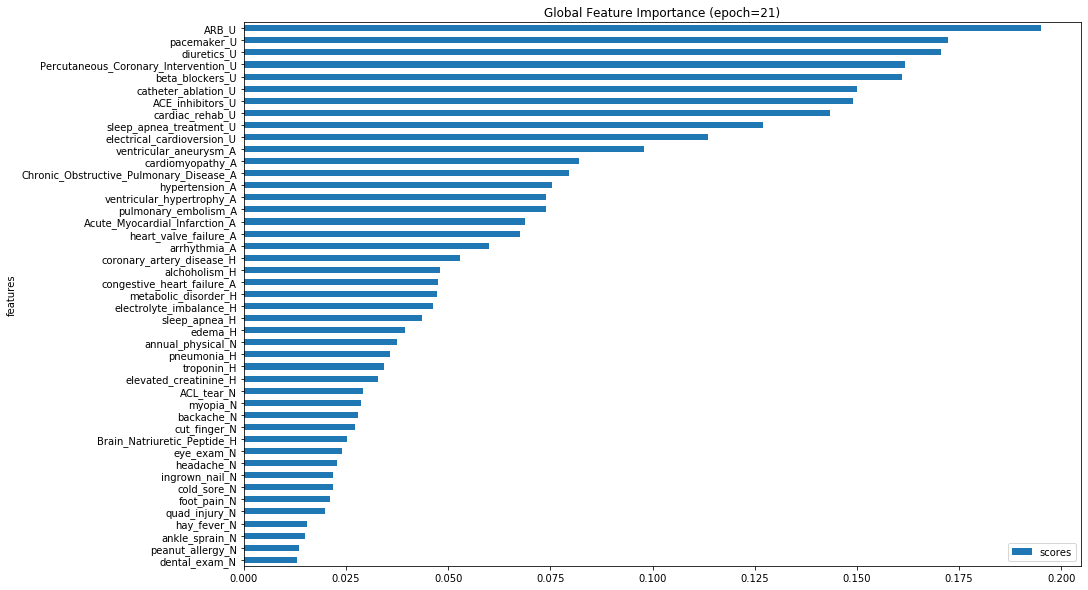

./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_22.pkl


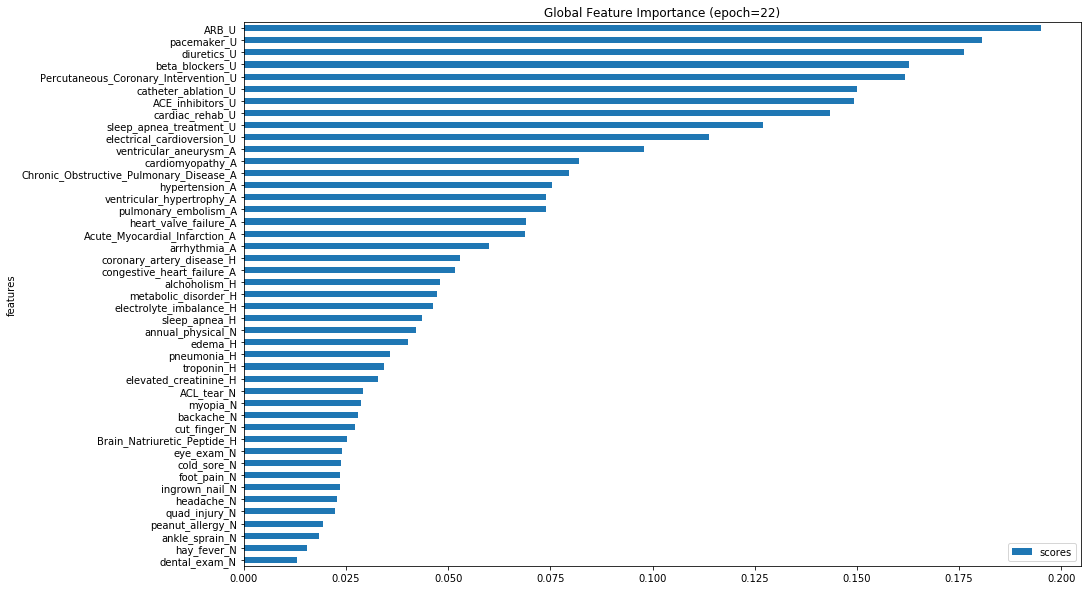

./output/time_diff_toy_dataset_v3/event_based/Final_Manually_Tuned/30/xgb/shap/val_shap_23.pkl


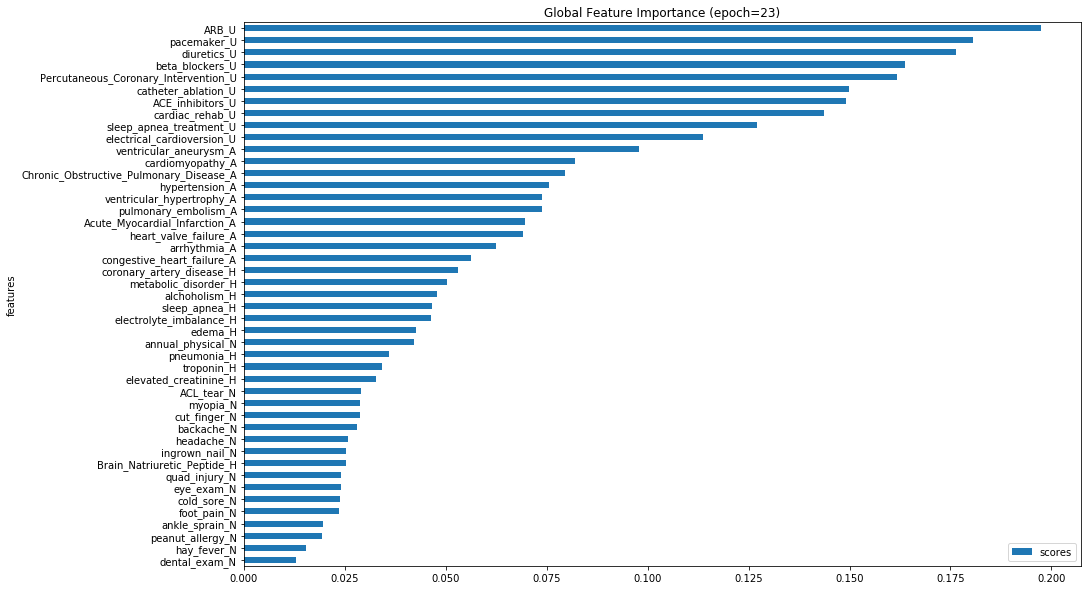

In [28]:
epochs = range(1, len(model_paths) + 1)
figsize = (15, 10)
for epoch in epochs:
    shap_path = shap_save_path_pattern.format("val", epoch)
    print(shap_path)
    val_results = sj_utils.load_pickle(shap_path)
    df_shap = get_features_and_global_shap(val_results)
    df_shap = df_shap.sort_values("scores", ascending=True)
    df_shap.plot(
        figsize=figsize,
        x="features",
        y="scores",
        kind="barh",
    )
    plt.title(f"Global Feature Importance (epoch={epoch})")
    plt.show()

In [29]:
data_dir = os.path.dirname(train_data_path)
patients_path = os.path.join(data_dir, "visualized_test_patients.txt")

with open(patients_path, "r") as fp:
    selected_patients = fp.readlines()
    print(selected_patients)
    selected_patients = [pat.strip() for pat in selected_patients]

selected_patients

['NGCBRFR511\n', '91S1IH3PSP\n', 'QFIS78CCHQ\n', '1GDD553507']


['NGCBRFR511', '91S1IH3PSP', 'QFIS78CCHQ', '1GDD553507']

In [112]:
epochs

range(1, 24, 10)

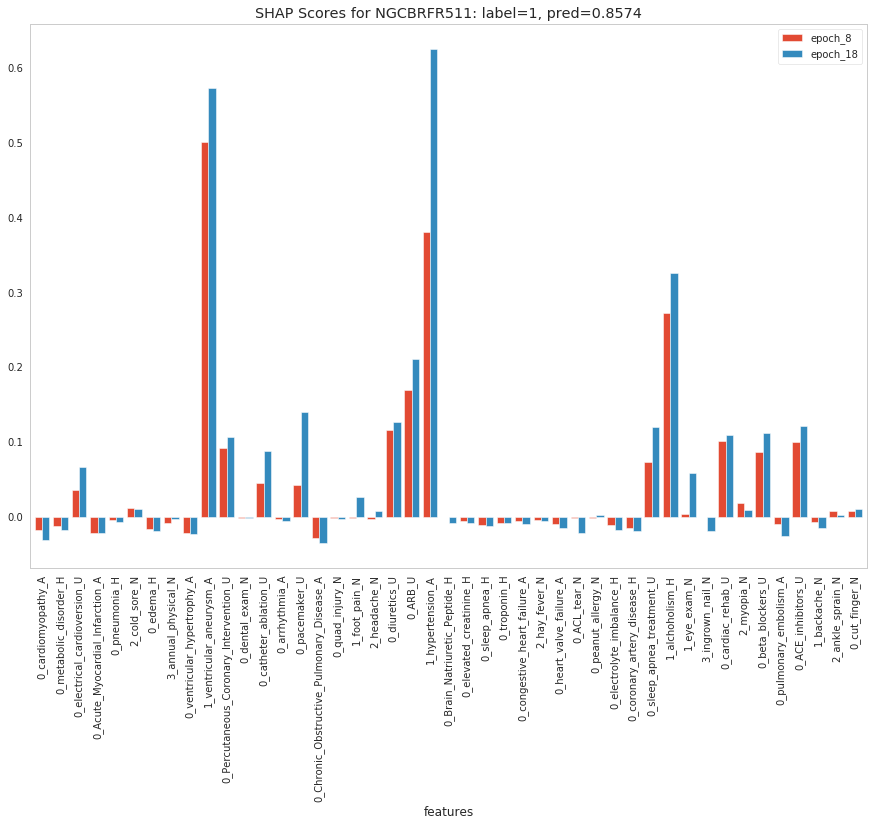

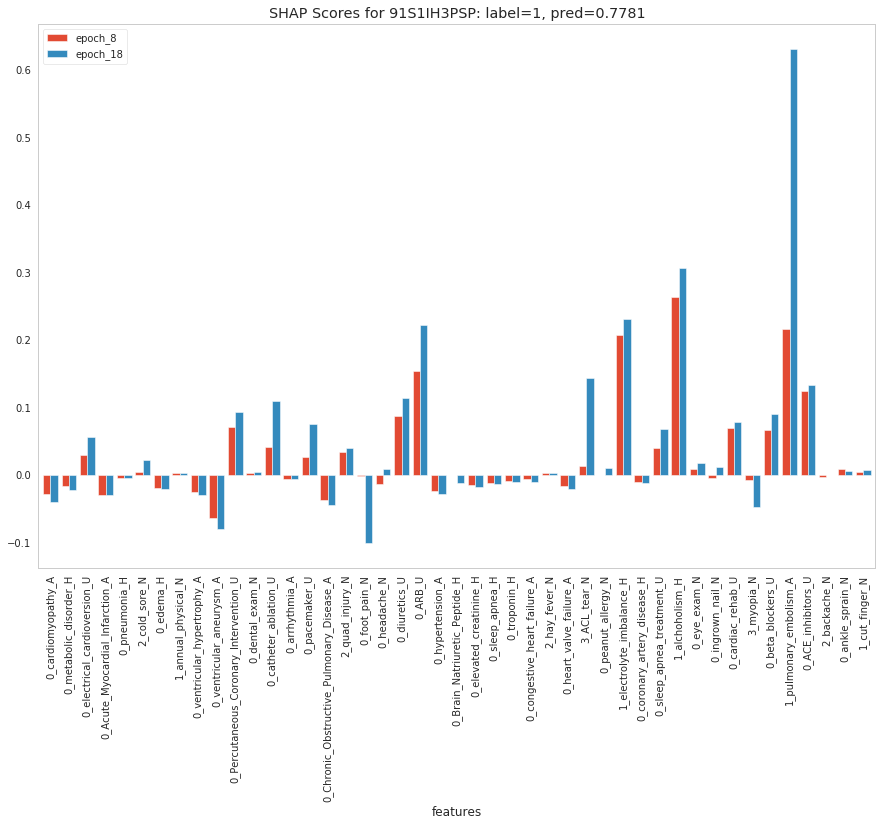

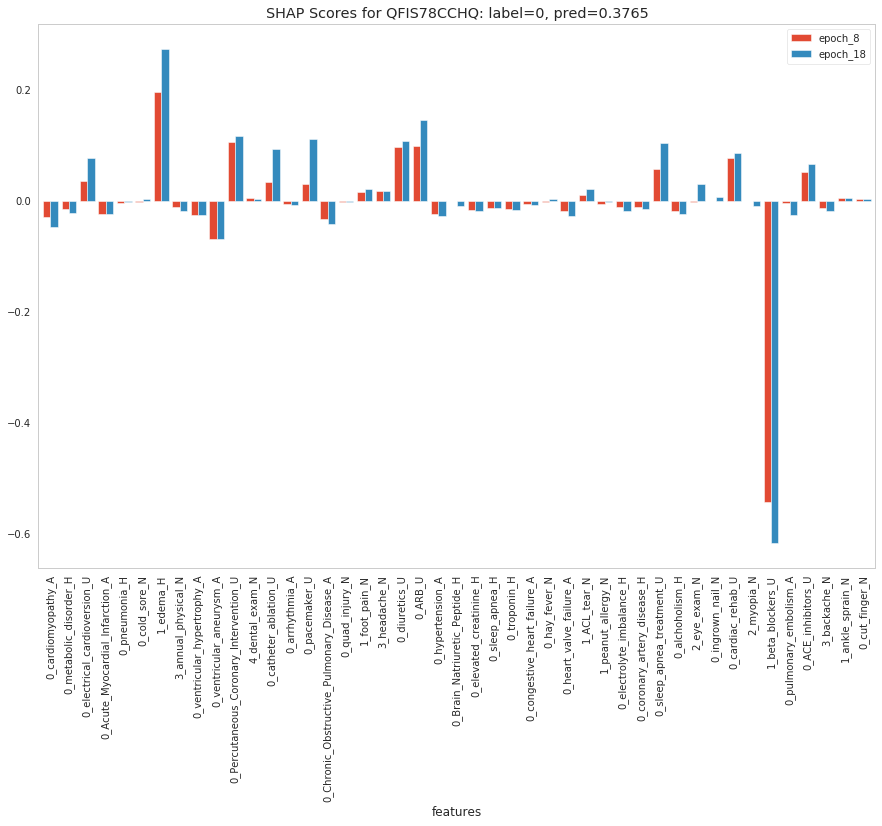

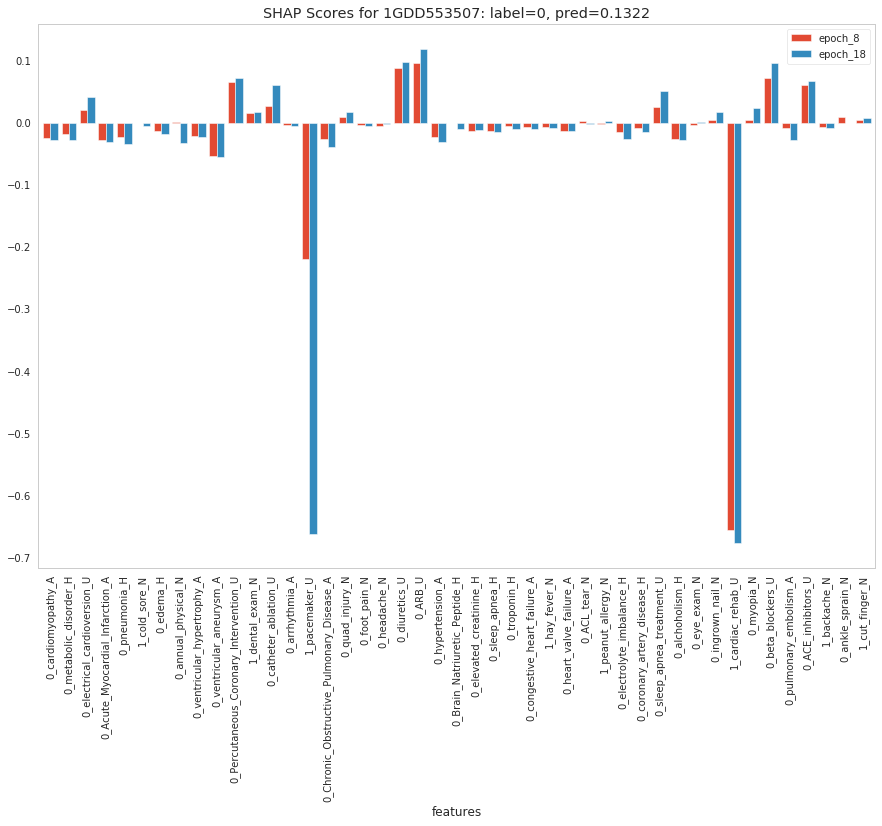

In [114]:
n_jobs = len(model_paths)
step = int(n_jobs / 2) - 1
# epochs = range(1, len(model_paths) + 1, 2)
epochs = [8, 18] #range(1, len(model_paths) + 1, step)
for patient_id in selected_patients:
    df = pd.DataFrame()
    label = None
    pred_prob = None
    for epoch in epochs:
        shap_path = shap_save_path_pattern.format("test", epoch)
        test_results = sj_utils.load_pickle(shap_path)
        if not len(df):
            features = test_results[patient_id]["features_xgb"]
            df["features"] = features
            df["values"] = df_test[features][
                df_test["patient_id"] == patient_id
            ].values[0]
            df["features"] = df["values"].astype(str) + "_" + df["features"]
            label = test_results[patient_id]["label"]
        pred_prob = test_results[patient_id]["xgb_pred"]
        df[f"epoch_{epoch}"] = test_results[patient_id]["xgb_shap"]
    figsize = (15, 10)
    epoch_cols = [f"epoch_{epoch}" for epoch in epochs]
    df.plot(
        figsize=figsize,
        x="features",
        y=epoch_cols,
        kind="bar",
        width=0.8,
    )
    plt.title(f"SHAP Scores for {patient_id}: label={label}, pred={pred_prob:.4}")
    plt.show()

In [387]:
selected_patients

['NGCBRFR511', '91S1IH3PSP', 'QFIS78CCHQ', '1GDD553507']

In [388]:
sel_patients_2 = selected_patients + list(test_results.keys())[:10]

In [389]:
test_results[patient_id].keys()

dict_keys(['features_xgb', 'label', 'xgb_pred', 'xgb_shap'])

In [390]:
df.head()

features  values   epoch_8  epoch_18
0               0_cardiomyopathy_A       0 -0.026891 -0.039665
1           0_metabolic_disorder_H       0 -0.012109 -0.018951
2     0_electrical_cardioversion_U       0  0.038144  0.069450
3  0_Acute_Myocardial_Infarction_A       0 -0.032425 -0.032735
4                    0_pneumonia_H       0 -0.011326 -0.018460

In [396]:
fig_dir = './XGB_perpatient_plots/'
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

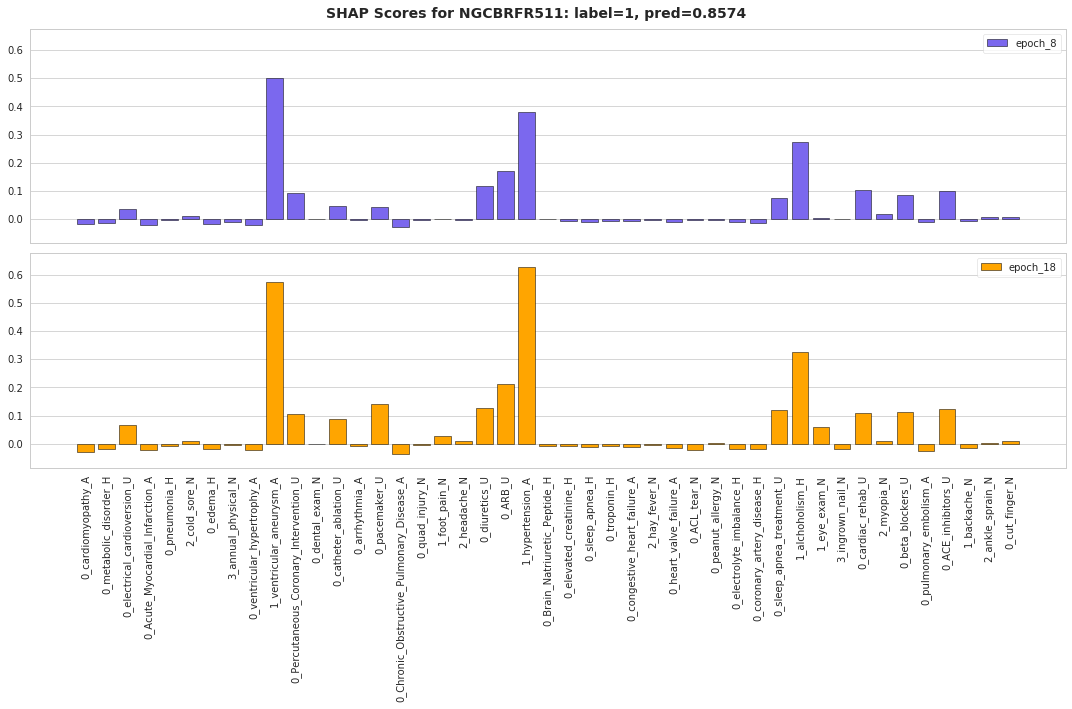

<Figure size 432x288 with 0 Axes>

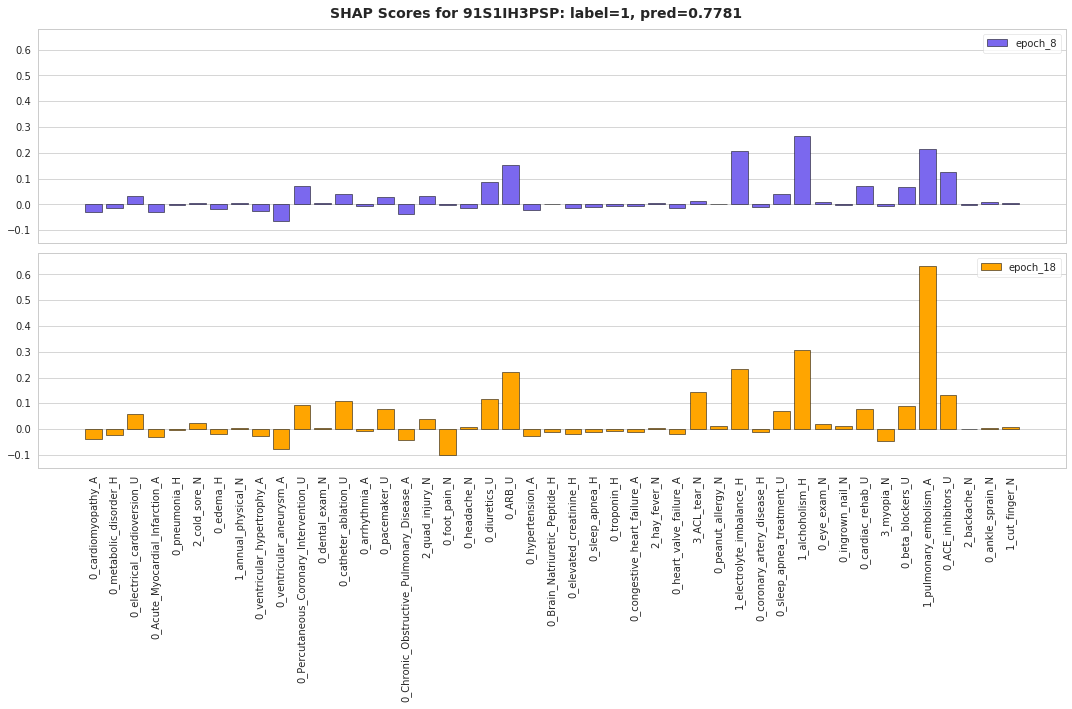

<Figure size 432x288 with 0 Axes>

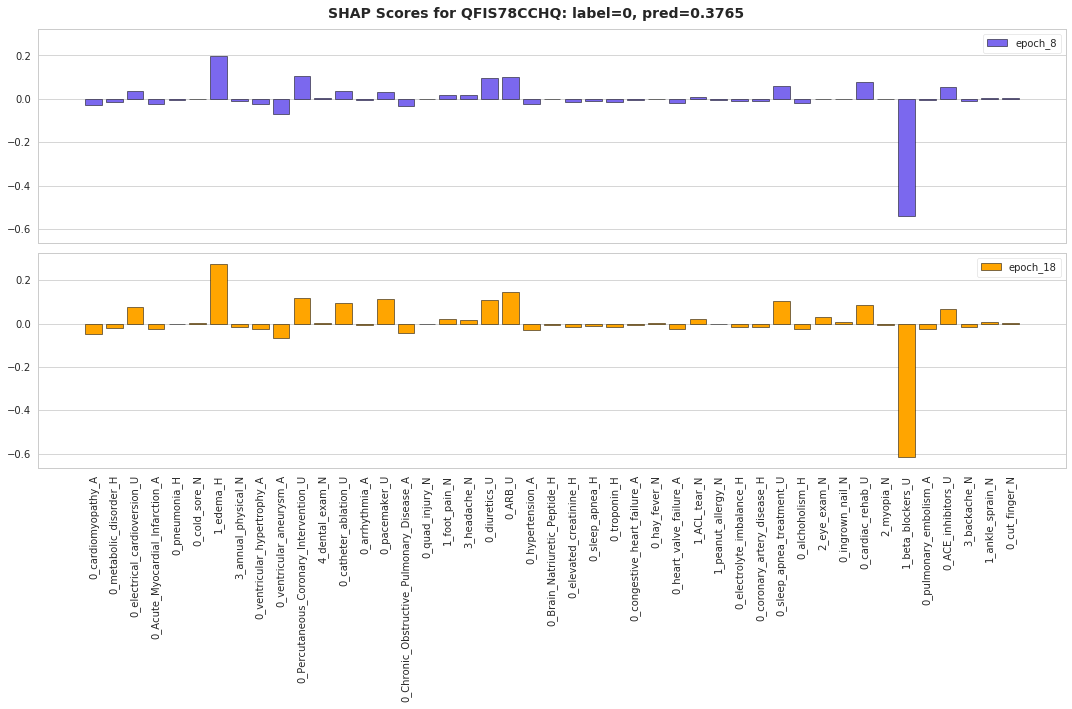

<Figure size 432x288 with 0 Axes>

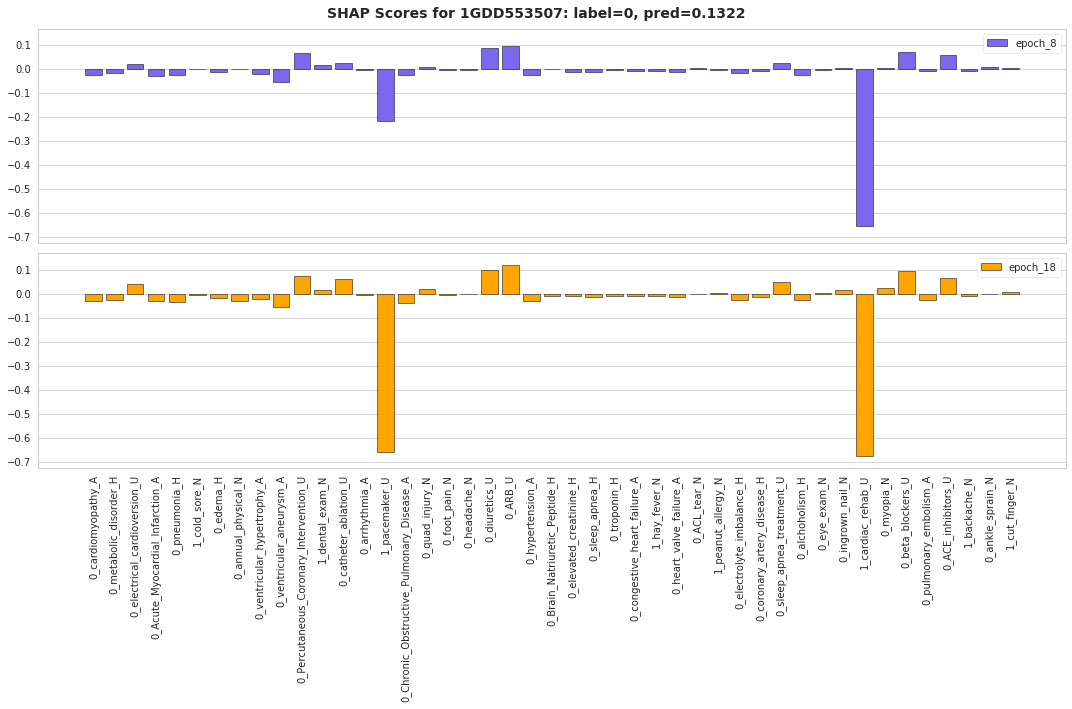

<Figure size 432x288 with 0 Axes>

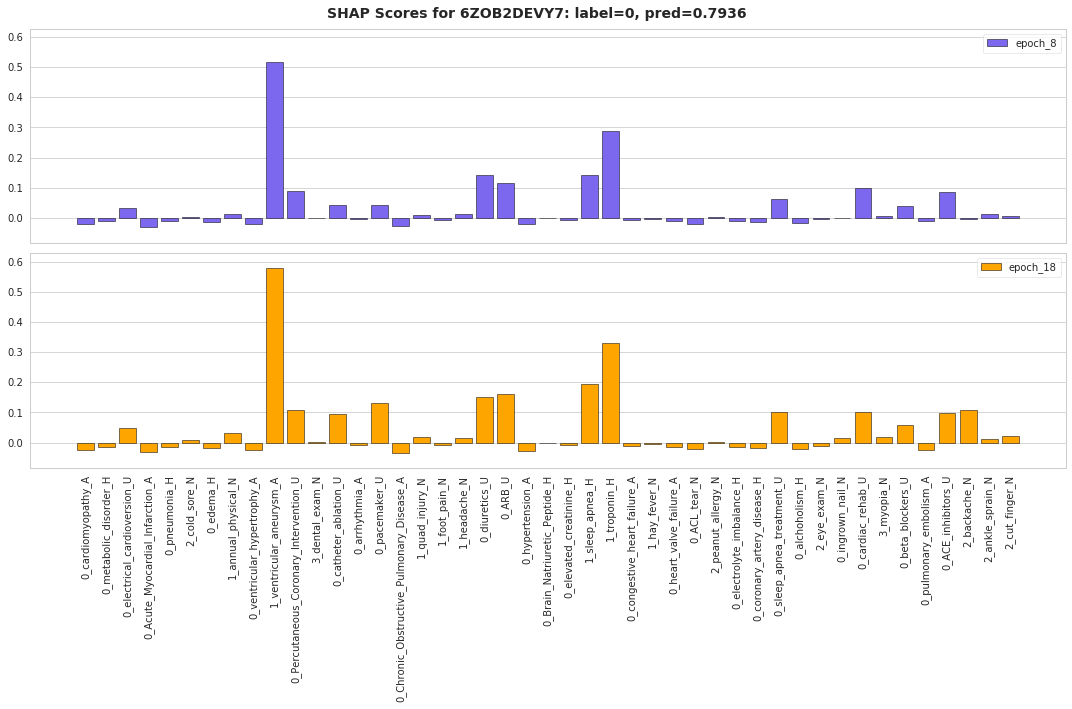

<Figure size 432x288 with 0 Axes>

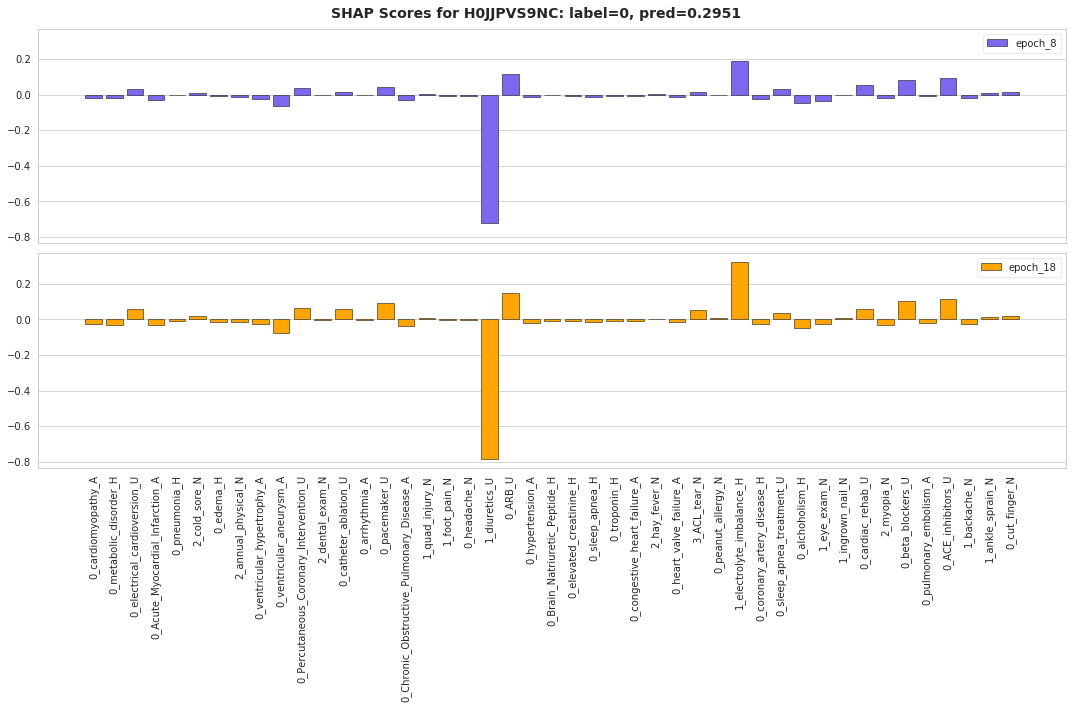

<Figure size 432x288 with 0 Axes>

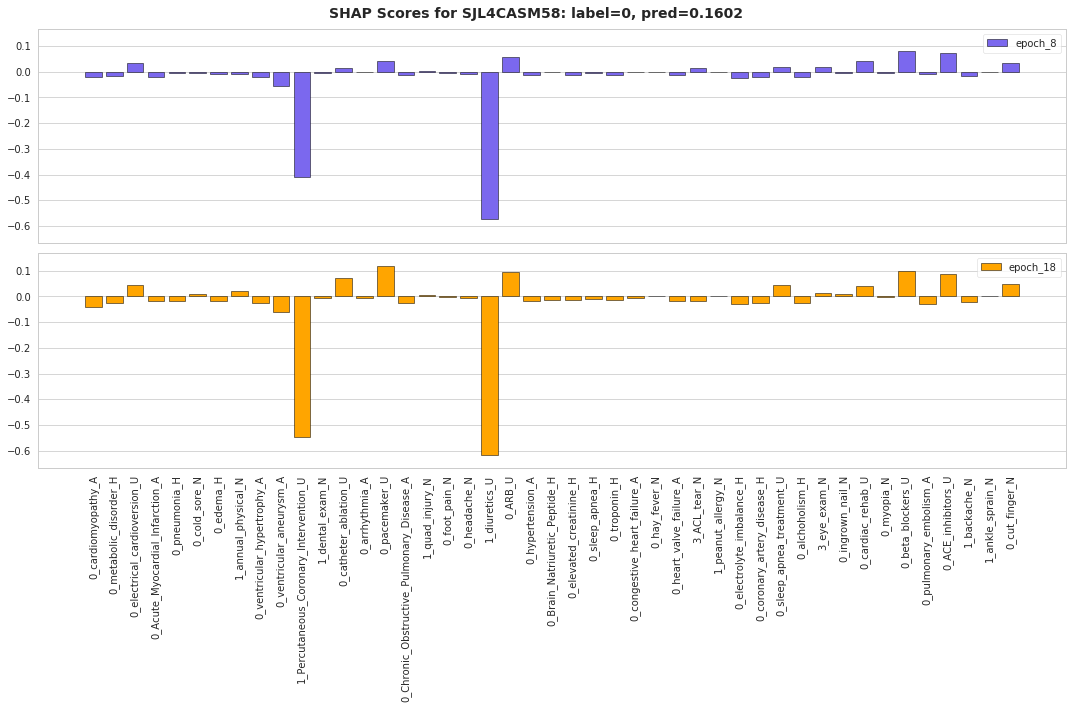

<Figure size 432x288 with 0 Axes>

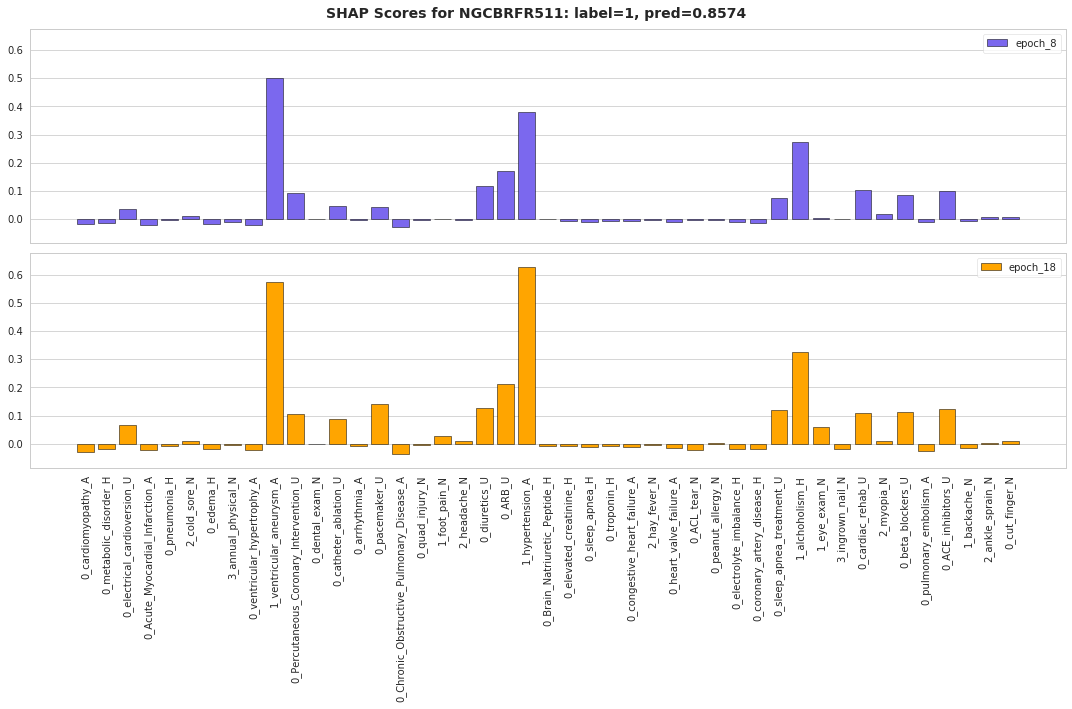

<Figure size 432x288 with 0 Axes>

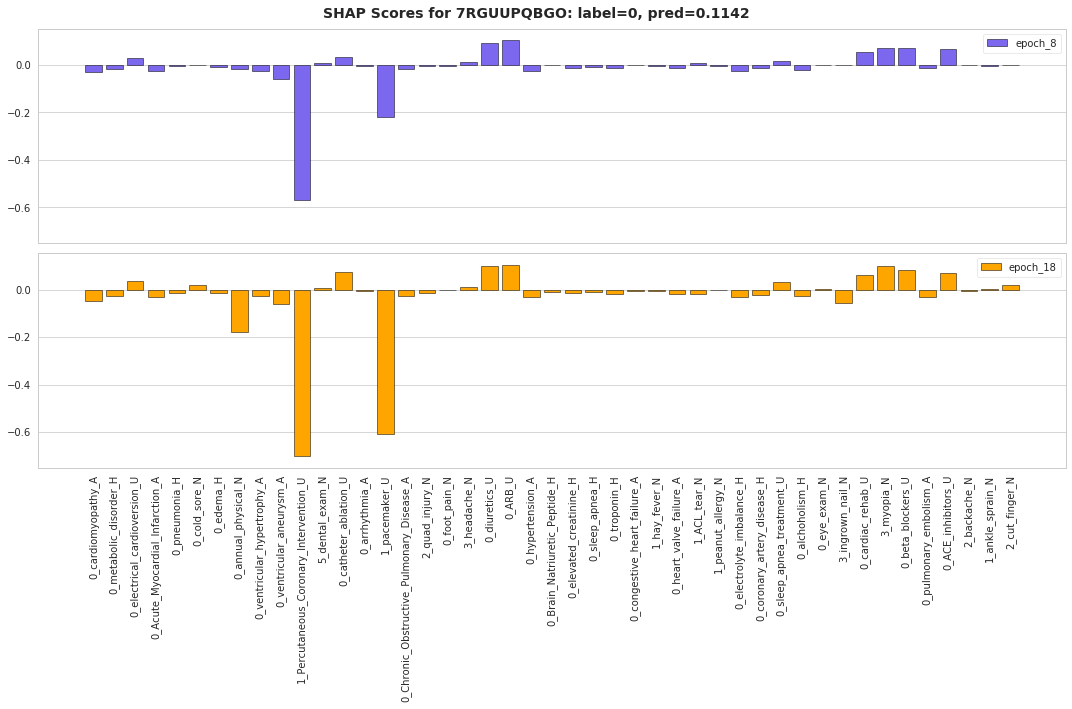

<Figure size 432x288 with 0 Axes>

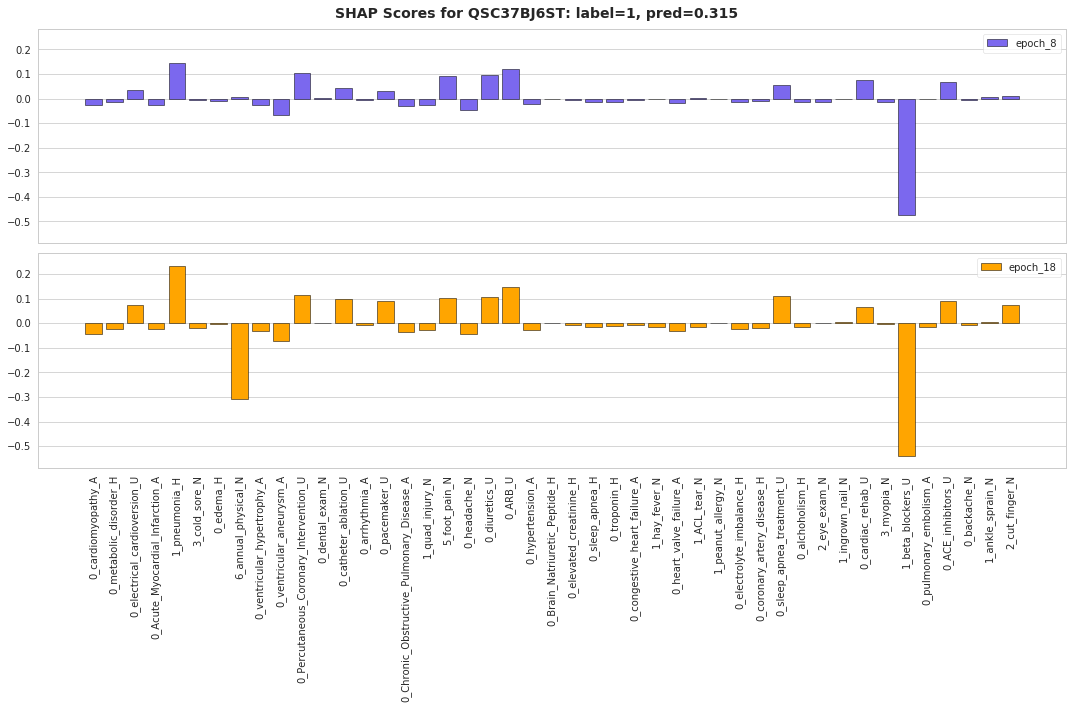

<Figure size 432x288 with 0 Axes>

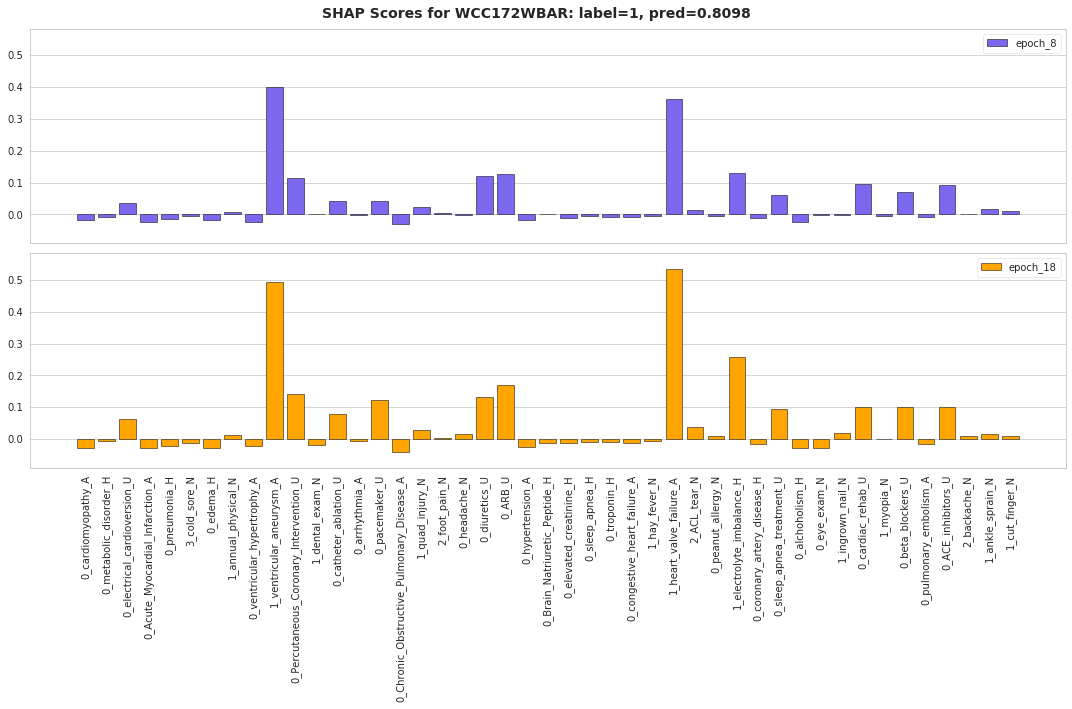

<Figure size 432x288 with 0 Axes>

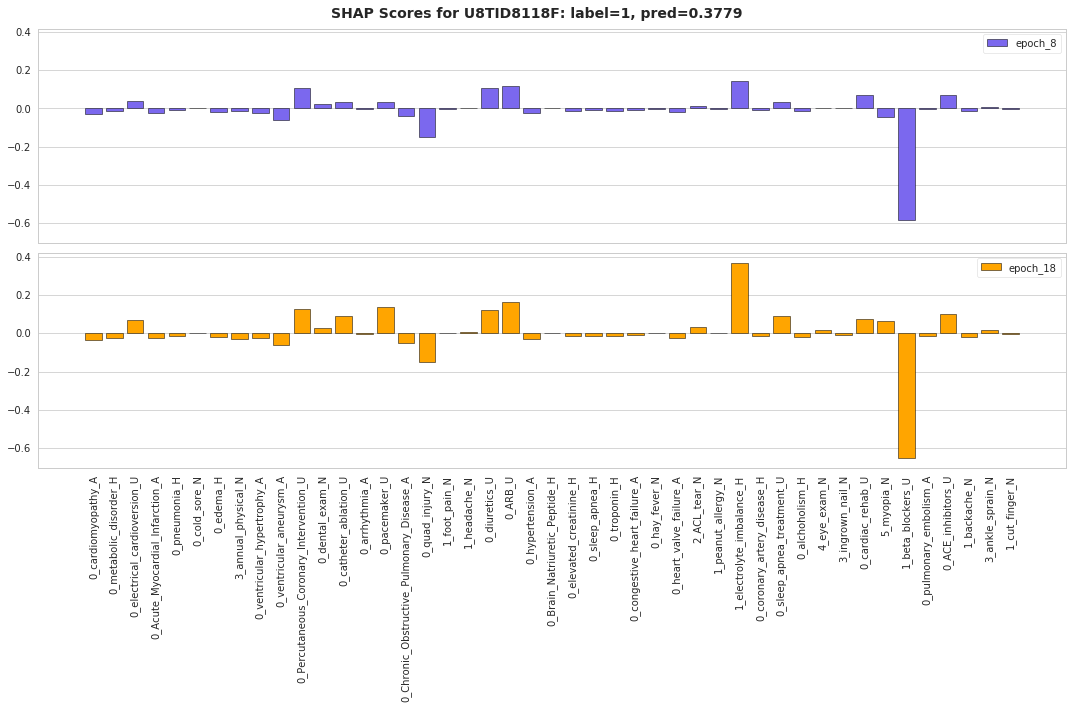

<Figure size 432x288 with 0 Axes>

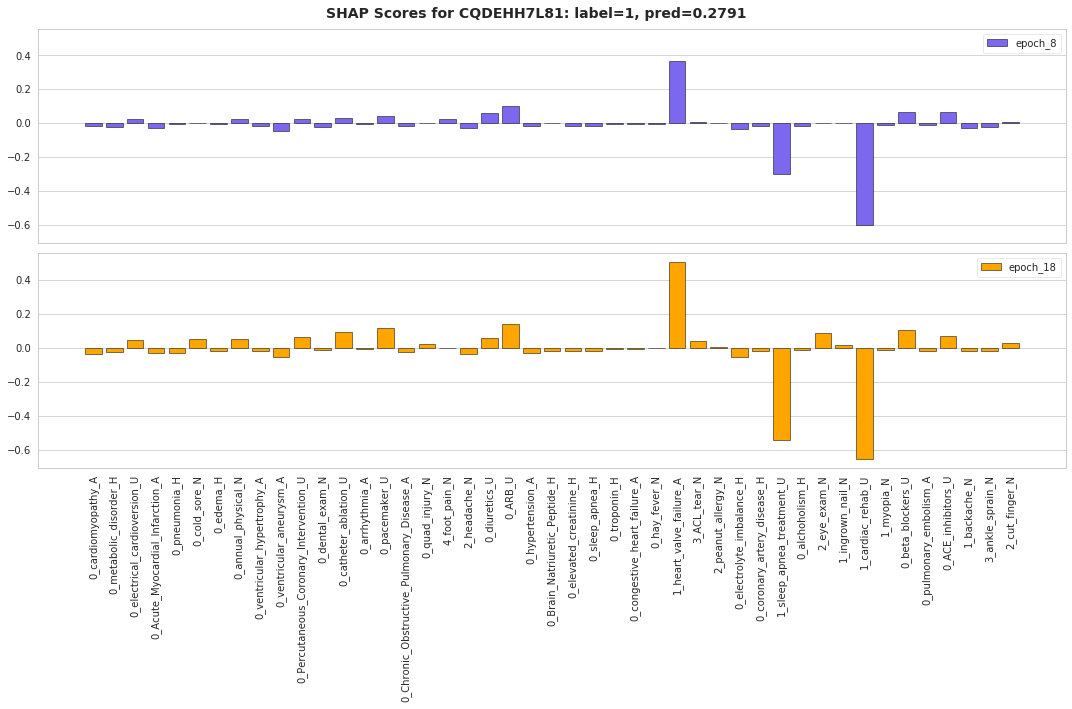

<Figure size 432x288 with 0 Axes>

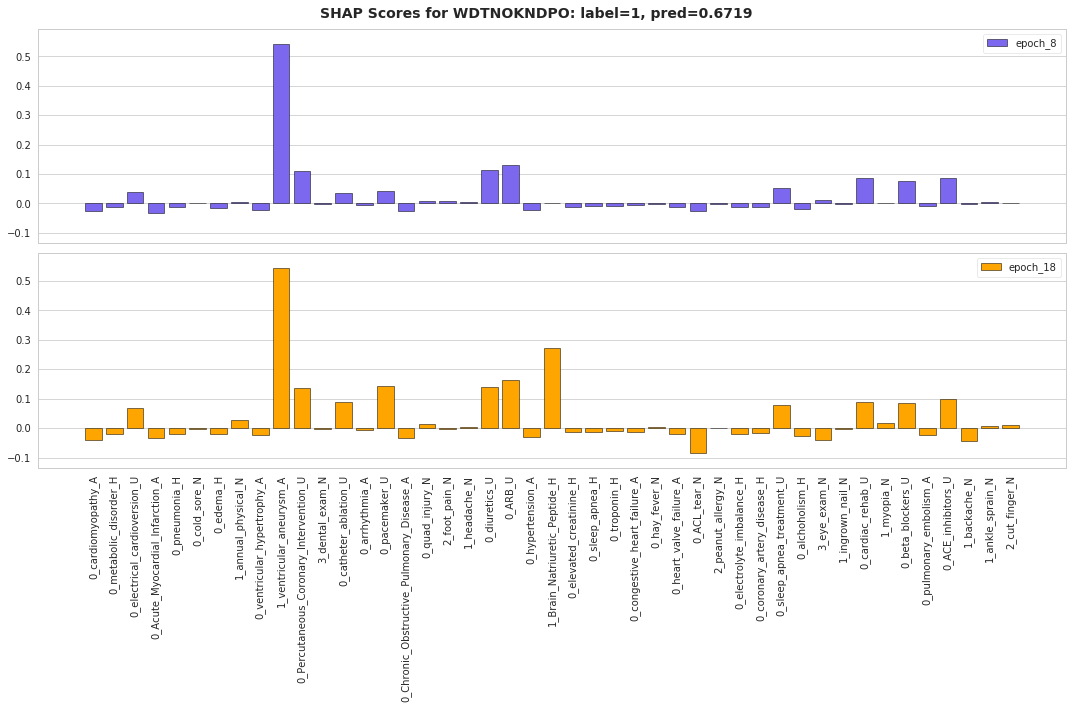

<Figure size 432x288 with 0 Axes>

In [398]:
n_jobs = len(model_paths)
step = int(n_jobs / 2) - 1
# epochs = range(1, len(model_paths) + 1, 2)
epochs = [8, 18] #range(1, len(model_paths) + 1, step)
for patient_id in sel_patients_2:
    df = pd.DataFrame()
    label = None
    pred_prob = None
    for epoch in epochs:
        shap_path = shap_save_path_pattern.format("test", epoch)
        test_results = sj_utils.load_pickle(shap_path)
        if not len(df):
            features = test_results[patient_id]["features_xgb"]
            df["features"] = features
            df["values"] = df_test[features][
                df_test["patient_id"] == patient_id
            ].values[0]
            df["features"] = df["values"].astype(str) + "_" + df["features"]
            label = test_results[patient_id]["label"]
        pred_prob = test_results[patient_id]["xgb_pred"]
        df[f"epoch_{epoch}"] = test_results[patient_id]["xgb_shap"]
        
    figsize = (15, 10)
    epoch_cols = [f"epoch_{epoch}" for epoch in epochs]
    
    fig = plt.figure(figsize=figsize)
    axes = fig.subplots(nrows=2, ncols=1)
    min_y, max_y = df[epoch_cols].values.min() - 0.05, df[epoch_cols].values.max() +0.05
    for row, epoch_col, color in zip(axes, epoch_cols, ['mediumslateblue', 'orange']):
        row.bar(
            df['features'], df[epoch_col], 0.8, label=epoch_col, color=color, edgecolor='black')
        if epoch_col != epoch_cols[-1]:
            row.set_xticks([])
        else:
            row.set_xticklabels(df['features'].tolist(), rotation=90)
        row.grid(axis='y')
        row.set_ylim((min_y, max_y))
        row.legend()
    
    plt.tight_layout()
    st = fig.suptitle(f"SHAP Scores for {patient_id}: label={label}, pred={pred_prob:.4}", 
                      fontsize=14, fontweight='bold')
    #st.set_y(0.95)
    fig.subplots_adjust(top=0.95) 
    
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, "XGB_perpatient_" + patient_id + f"_label{label}.png"), dpi=600)
    plt.show()

In [31]:
# n_exps = 10
# df = pd.DataFrame()
# for n_exp in range(1, n_exps + 1):
#     summary_path = f"output/Final_Manually_Tuned/{seq_len}/{n_exp:02}/{model_name}/train_results/results.csv"
#     df_summary = pd.read_csv(summary_path)
#     df_summary.set_index("epoch", inplace=True)
#     best_epoch = df_summary["val_GT_shap_sim"].idxmax()

#     best_results_path = f"./output/Final_Manually_Tuned/{seq_len}/{n_exp:02}/{model_name}/shap/test_shap_{best_epoch}.pkl"
#     dict_results = sj_utils.load_pickle(best_results_path)
#     df_shap = get_features_and_global_shap(dict_results, n_exp)

#     df = pd.concat([df, df_shap], axis=0)

In [32]:
# df.head()

In [33]:
# plt.figure(figsize=(15, 10))
# df_mean = df.groupby("features")["scores"].mean()
# df_mean.sort_values(ascending=False, inplace=True)
# df_mean_cols = df_mean.index
# ax = sns.boxplot(x="features", y="scores", data=df, order=df_mean_cols)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# plt.show()

In [34]:
# Copy best models results to S3
# n_exps = 10
# for n_exp in range(1, n_exps + 1):
#     print(f"Copying best model data to s3 for exp={n_exp}...")
#     summary_path = f"output/Final_Manually_Tuned/{seq_len}/{n_exp:02}/{model_name}/train_results/results.csv"
#     df_summary = pd.read_csv(summary_path)
#     df_summary.set_index("epoch", inplace=True)
#     best_epoch = df_summary["val_GT_shap_sim"].idxmax()

#     model_path = f"./output/Final_Manually_Tuned/30/10/xgb/models/model_{best_epoch}.pkl"
#     val_best_path = f"./output/Final_Manually_Tuned/{seq_len}/{n_exp:02}/{model_name}/shap/val_shap_{best_epoch}.pkl"
#     test_best_path = f"./output/Final_Manually_Tuned/{seq_len}/{n_exp:02}/{model_name}/shap/test_shap_{best_epoch}.pkl"

#     s3_dir = f"s3://merck-paper-bucket/Synthetic-events/final_event_30_xgb/{n_exp}/"

#     # copy files to s3
#     command_pattern = f"aws s3 cp {'{}'} {s3_dir}"

#     command = command_pattern.format(summary_path)
#     os.system(command)

#     command = command_pattern.format(model_path)
#     os.system(command)

#     command = command_pattern.format(val_best_path)
#     os.system(command)

#     command = command_pattern.format(test_best_path)
#     os.system(command)
# print("Models data successfully copied to S3!")